# A simple economic model with an analytical solution

In this notebook, we use `TensorFlow 1.13.1` to showcase the general workflow of setting up and solving dynamic general equilibrium models with _deep equilibrium nets_. Use `pip install tensorflow==1.13.1` to install the correct version.

The notebook accompanies the working paper by [Azinovic, Gaegauf, & Scheidegger (2020)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3393482) and corresponds to the model solved in appendix C with a slighly different model calibration.

Note that this is a minimal working example for illustration purposes only. A more extensive implementation will be published on Github. 

The economic model we are solving in this example is one for which we know an exact solution. We chose to solve a model from [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118), which is based on [Huffman (1987)](https://www.journals.uchicago.edu/doi/10.1086/261445), because, in addition to being analytically solvable, it is closely related to the models solved in the paper. Therefore, the approach presented in this notebook translates directly to the models in working paper.

## The model <a id='model'></a>

We outline the model briefly. 

### tldr
The model has $A$ agents that only work in the first period of their lives. They optimize lifetime log utility by saving in risky capital. Agents consume everything in the last period. There is a representative firm that produces with labor and capital and is affected by TFP and depreciation shocks. The firm pays market prices for labor and capital.

***

### Households
Agents live for $A$ (here we consider $A = 6$) periods and have log utility. Agents only work in the first period of their life: $l^h_t=1$ for $h=0$ and $l^h_t=0$ otherwise. Therefore, the aggregate labor supply is constant and equal to one: $L_t=1$. Agents receive a competitive wage and can save in risky capital. Households cannot die with debt. Otherwise, there are no constraints or adjustment costs.
The household's problem is

$$ \max_{\{c_{t+i}^{i}, a_{t+i}^{i}\}_{i=0}^{A-1}}\mathbb{E}_{t}{\sum_{i=0}^{A-1}\log(c_{t+i}^{i})} $$
subject to:
$$c_{t}^{h} + a_t^{h} = r_t k_t^h + w_t l^h_t$$
$$k^{h+1}_{t+1} = a_t^h $$
$$a^{A-1}_t \geq 0$$

where $c_t^h$ denotes the consumption of age-group $h$ at time $t$, $a^h_t$ denotes the saving, $k_t^h$ denotes the available capital in the beginning of the period, $r_t$ denotes the price of capital, $l_t^h$ denotes the exogenously supplied labor endowment, and $w_t$ denotes the wage.

### Firms

There is a single representative firm with Cobb-Douglas production function.
The production function is given by
$$f(K_t,L_t,z_t) = \eta_t K^{\alpha}_t L^{1-\alpha}_t + K_t(1-\delta_t),$$
where $K_t$ denotes aggregate capital, where
$$K_t = \sum_{h=0}^{A-1} k^h_t,$$
$L_t$ denotes the aggregate labor supply, where
$$L_t = \sum_{h=0}^{A-1} l^h_t,$$
$\alpha$ denotes the capital share in production, $\eta_t$ denotes the stochastic TFP, and $\delta_t$ denotes the stochastic depreciation. The firm's optimization problem implies that the return on capital and the wage are given by
$$r_t = \alpha \eta_t K_t^{\alpha - 1} L_t^{1 - \alpha} + (1 - \delta_t),$$
$$w_t = (1 - \alpha) \eta_t K_t^{\alpha} L_t^{-\alpha}.$$

## Equilibrium

A competitive equilibrium, given initial conditions $z_0, \{ k_0^s \}_{s=0}^{A-1}$, is a collection of choices for households $ \{ (c_t^s, a_t^s)_{s = 0}^{A-1} \}_{t=0}^\infty$ and for the representative firm $(K_t, L_t)_{t=0}^\infty$ as well as prices $(r_t, w_t)_{t=0}^\infty$, such that

1. given prices, households optimize,
2. given prices, the firm maximizes profits,
3. markets clear.


## Table of contents

0. [Set up workspace](#workspace)
1. [Model calibration](#modelcal)
2. [_Deep equilibrium net_ hyper-parameters](#deqnparam)
    1. [Neural network](#nn)
3. [Economic model](#econmodel)
    1. [Current period (t)](#currentperiod)
    2. [Next period (t+1)](#nextperiod)
    3. [Cost/Euler function](#cost)
4. [Training](#training)

## 0. Set up workspace <a id='workspace'></a>

First, we need to set up the workspace. All of the packages are standard python packages. This version of the _deep equilibrium net_ notebook will be computed with `TensorFlow 1.13.1`. Make sure you are working in an environment with TF1 installed. Use `pip install tensorflow==1.13.1` to install the correct version.

The only special module is `utils` from which we import a mini-batch function `random_mini_batches` and a function that initializes the neural network weights `initialize_nn_weight`.

### Saving and continuing training

You can save and resume training by saving and loading the tensorflow session and data starting point.
* The saved session stores the neural network weights and the optimizer's state. If you have saved a session that you would like to reload, set `sess_path` to the session checkpoint path. For example, to load the 100th episode's session set `sess_path = './output/sess_100.ckpt'`. Otherwise, set `sess_path` to `None` to train from scratch. Currently, this script saves the session at the end of each [episode](#deqnparam).
* The saved data starting point stores the an exogeneous shock and a capital distribution, which can be used to simulate states into the future from. If you have saved a starting point that you would like to reload, set `data_path` to the numpy data path. For example, to load the 100th episode's starting point set `data_path = './output/data_100.npy'`. Otherwise, set `data_path` to `None` to train from scratch.

In [1]:
%matplotlib notebook
    # Use %matplotlib notebook to get zoom-able & resize-able notebook. 
    # This is the best for quick tests where you need to work interactively.

# Import modules
import os
import re
from datetime import datetime

import tensorflow as tf
import numpy as np
from utils import initialize_nn_weight, random_mini_batches

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
std_figsize = (4, 4)

# Make sure that we are working with tensorflow 1
print('tf version:', tf.__version__)
assert tf.__version__[0] == '1'

# Set the seed for replicable results
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
    # Set global numpy & tensorflow seed = 42

# Helper variables
eps = 0.00001  # Small epsilon value

# Make output directory to save network weights and starting point
if not os.path.exists('./output'):
    os.mkdir('./output')

# Path to saved tensorflow session
sess_path = None
# Path to saved data starting point
data_path = None

/Users/min/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/min/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/min/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/min/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

tf version: 1.13.1


## 1. Model calibration <a id='modelcal'></a>

### tldr

We solve a model with 6 agents. There are 4 exogenous shock which are the product of 2 depreciation ($\delta \in \{0.5, 0.9\}$) and 2 TFP shocks ($\eta \in \{0.95, 1.05\}$). Each shock-state has an equal probably of 0.25 of realizing in the next period. Agents only work in the first period. The economic parameters are calibrated to: $\alpha = 0.3$, $\beta=0.7$, and $\gamma = 1.0$.

***

We solve the model for $A = 6$ agents and base our parameterization on [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118). 

### Shocks
The depreciation $\delta$ takes one of two values, $\delta \in \{0.5, 0.9\}$. The TFP $\eta$ also takes one of two values, $\eta \in \{0.95, 1.05\}$.
Both the TFP and depreciation shocks are i.i.d. with a transition matrix:
\begin{equation}
\Pi^{\eta} = \Pi^{\delta}=
\begin{bmatrix}
0.5 & 0.5 \\
0.5 & 0.5
\end{bmatrix}.
\end{equation}
and evolve independently of each other. In total, there are four possible combinations of depreciation shock and TFP shock that are labeled by $z \in \mathcal{Z}=\{1,2,3,4\}$ and correspond to $\delta=[0.5, 0.5, 0.9, 0.9]^T$ and $\eta=[0.95, 1.05, 0.95, 1.05]^T$. The overall transition matrix is given by
\begin{equation}
\Pi= \Pi^{\delta} \otimes \Pi^{\eta} = \begin{bmatrix}
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25
\end{bmatrix},
\end{equation} where $\Pi_{i, j}$ denotes the probability of a transition from the exogenous shock $i$ to exogenous shock $j$, where $i,j \in \mathcal{Z}$. 

### Labor
Agents in this economy are alive for 6 periods. Agents work in the first period of their lives before retiring for the remaining 4. That is, their labor endowment during their working age is 1 (and 0 otherwise).

### Production and household parameters
The output elasticity of the Cobb-Douglas production function is $\alpha = 0.3$, the discount factor of agents' utility is $\beta=0.7$, and the coeffient of risk aversion (in CRRA utility) is $\gamma = 1.0$.


In [8]:
# Number of agents and exogenous shocks
num_agents = A = 6
num_exogenous_shocks = 4

# Exogenous shock values
delta = tf.constant([[0.5], [0.5], [0.9], [0.9]],  dtype=tf.float32)  
    # Capital depreciation (dependent on shock)
eta = tf.constant([[0.95], [1.05], [0.95], [1.05]], dtype=tf.float32)  
    # TFP shock (dependent on shock)

# Transition matrix
# In this example we hardcoded the transition matrix. 
# Changes cannot be made without also changing the corresponding code below.
p_transition = 0.25  # All transition probabilities are 0.25
pi_np = p_transition * np.ones((4, 4))  # Transition probabilities
pi = tf.constant(pi_np, dtype=tf.float32)  # Transition probabilities

# Labor endowment
labor_endow_np = np.zeros((1, A))
labor_endow_np[:, 0] = 1.0  # Agents only work in their first period
labor_endow = tf.constant(labor_endow_np, dtype=tf.float32)

# Production and household parameters
alpha = tf.constant(0.3)  # Capital share in production
beta_np = 0.7
beta = tf.constant(beta_np, dtype=tf.float32)  # Discount factor (patience)
gamma = tf.constant(1.0, dtype=tf.float32)  # CRRA coefficient

## 2. _Deep equilibrium net_ hyper-parameters <a id='deqnparam'></a>

Here, we will briefly outline the _deep equilibrium net_ architecture and choice of hyper-parameters. By hyper-parameters, we refer too all of the parameters that can be chosen freely by the modeller. This is in contrast to "parameters", which refers to the neural network weights that are learned during training.
We found it helpful to augment the state we pass to the neural network with redundant information, such as aggregate variables and the distribution of financial wealth.
In this notebook, we do the same.

  * Neural network architecture (see NN diagram below):
    * The neural network takes an extended state that is 32-dimensional:
        * Natural state:
            * 1 dimension for the shock index,
            * 6 dimensions for the distribution of capital across age groups
        * Redundant extension:
            * 1 dimension for the current TFP,
            * 1 dimension for the current depreciation,
            * 1 dimension for aggregate capital,
            * 1 dimension for aggregate labor supply, 
            * 1 dimension for the return on capital,
            * 1 dimension for the wage,
            * 1 dimension for the aggregate production,
            * 6 dimensions for the distribution of financial wealth,
            * 6 dimensions for the distribution of labor income, 
            * 6 dimensions for the distribution of total income.
    * The first and second hidden layers have 100 and 50 nodes, respectively.
    * The output layer is 5-dimensional.
  * Training hyper-parameters:
    * We simulate 5'000 episodes.*
    * Per episode, we compute 20 epochs.
    * We use a minibatch size of 512.
    * Each episode is 10'240 periods long.
    * The learning rate is set to 0.00001.

\* In the _deep equilibrium net_ framework we iterate between a simulation and training phase (see [training](#training)). We first simulate a training dataset based on the current state of the neural network. That is, we simulate a random sequence of exogenous shocks for which we compute the capital holdings of the agents. We call the set of simulated periods an _episode_. 5'000 episodes means that we re-simulate the training data 5'000 times.

Note that this calibration is not optimal for the economic model being solved. This script is intended to provide a simple introduction to _deep equilibrium nets_ and not an indepth discussion on optimizing the performance.

<img src='analytic_NN1.png' style="width:1000px">

In [13]:
num_episodes = 5000 
len_episodes = 10240
epochs_per_episode = 20
minibatch_size = 512
num_minibatches = int(len_episodes / minibatch_size)
lr = 0.00001
    # Is it necessary to be so slow?

# Neural network architecture parameters
num_input_nodes = 8 + 4 * A  
    # Dimension of extended state space (8 aggregate quantities and 4 distributions)
num_hidden_nodes = [100, 50]  
    # Dimension of hidden layers
num_output_nodes = (A - 1)  
    # Output dimension (capital holding for each agent. Agent 1 is born without capital (k^1=0))

### 2.A. Neural network <a id='nn'></a>

Since we are using a neural network with 2 hidden layers, the network maps:
$$X \rightarrow \mathcal{N}(X) = \sigma(\sigma(XW_1 + b_1)W_2 + b_2)W_3 + b_3$$
where $\sigma$ is the "rectified linear unit (ReLU)" activation function and the output layer is activated with the linear function (which is the identity function and hence omitted from the equation). Therefore, we need 3 weight matrices $\{W_1, W_2, W_3\}$ and 3 bias vectors $\{b_1, b_2, b_3\}$ (compare with the neural network diagram above). In total, we train **5'954 (why not 3200 + 5000 + 250 + 155 = 8605 ?)**  parameters:

| $W_1$ | $32 \times 100$  | $= 3200$ |
| --- | --- | --- |
| $W_2$ | $100 \times 50$ | $= 5000$ |
| $W_3$ | $50 \times 5$ | $= 250$ |
| $b_1 + b_2 + b_3$ | $100 + 50 + 5$ | $= 155$|


We initialize the neural network parameters with the  `initialize_nn_weight` helper function from `utils`.

Then, we compute the neural network prediction using the parameters in `nn_predict`. 

In [14]:
# We create a placeholder for X, the input data for the neural network, 
# which corresponds to the state.
X = tf.placeholder(tf.float32, shape=(None, num_input_nodes))
# Get number samples
m = tf.shape(X)[0]

# We create all of the neural network weights and biases. The weights are matrices that
# connect the layers of the neural network. For example, W1 connects the input layer to
# the first hidden layer
W1 = initialize_nn_weight([num_input_nodes, num_hidden_nodes[0]])
W2 = initialize_nn_weight([num_hidden_nodes[0], num_hidden_nodes[1]])
W3 = initialize_nn_weight([num_hidden_nodes[1], num_output_nodes])

# The biases are extra (shift) terms that are added to each node in the neural network.
b1 = initialize_nn_weight([num_hidden_nodes[0]])
b2 = initialize_nn_weight([num_hidden_nodes[1]])
b3 = initialize_nn_weight([num_output_nodes])

# Then, we create a function, to which we pass X, that generates a prediction based on
# the current neural network weights. Note that the hidden layers are ReLU activated.
# The output layer is not activated (i.e., it is activated with the linear function).
def nn_predict(X):
    hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))
    hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, W2), b2))
    output_layer = tf.add(tf.matmul(hidden_layer2, W3), b3)
    return output_layer


Instructions for updating:
Colocations handled automatically by placer.


## 3. Economic model <a id='econmodel'></a>

In this section, we implement the economics outlined in [the model](#model).

Each period, based on the current distribution of capital and the exogenous state, agents decide whether and how much to save in risky capital and to consume. Their savings together with the labor supplied implies the rest of the economic state (e.g., capital return, wages, incomes, ...). We use the neural network to generate the savings based on the agents' capital holdings at the beginning of the period. The remaining economic state is computed using the equations outlined [above](#model). The economic mechanisms are encoded in helper functions. We create one for the `firm`, the `shocks`, and `wealth` (see cell below).

Then, in the face of future uncertainty, the agents again decide whether and how much to save in risky capital for the next period. We use the neural network to generate new savings for each of the future states (one for each shock). The input state for these network predictions is the next period's capital holding which are current periods savings.

First, we define the helper functions for the `firm`, the `shocks`, and `wealth`.


In [18]:
def firm(K, eta, alpha, delta):
    """Calculate return, wage and aggregate production.
    
    r = eta * K^(alpha-1) * L^(1-alpha) + (1-delta)
    w = eta * K^(alpha) * L^(-alpha)
    Y = eta * K^(alpha) * L^(1-alpha) + (1-delta) * K 

    Args:
        K: aggregate capital,
        eta: TFP value,
        alpha: output elasticity,
        delta: depreciation value.

    Returns:
        return: return (marginal product of capital), 
        wage: wage (marginal product of labor).
        Y: aggregate production.
    """
    L = tf.ones_like(K)

    r = alpha * eta * K**(alpha - 1) * L**(1 - alpha) + (1 - delta)
    w = (1 - alpha) * eta * K**alpha * L**(-alpha)
    Y = eta * K**alpha * L**(1 - alpha) + (1 - delta) * K

    return r, w, Y

def shocks(z, eta, delta):
    """Calculates tfp and depreciation based on current exogenous shock.

    Args:
        z: current exogenous shock (in {1, 2, 3, 4}),
        eta: tensor of TFP values to sample from,
        delta: tensor of depreciation values to sample from.

    Returns:
        tfp: TFP value of exogenous shock, 
        depreciation: depreciation values of exogenous shock.
    """
    tfp = tf.gather(eta, tf.cast(z, tf.int32))
    depreciation = tf.gather(delta, tf.cast(z, tf.int32))
    return tfp, depreciation
    
def wealth(k, R, l, W):
    """Calculates the wealth of the agents.

    Args:
        k: capital distribution,
        R: matrix of return,
        l: labor distribution,
        W: matrix of wages.

    Returns:
        fin_wealth: financial wealth distribution,
        lab_wealth: labor income distribution,
        tot_income: total income distribution.
    """
    fin_wealth = k * R
    lab_wealth = l * W
    tot_income = tf.add(fin_wealth, lab_wealth)
    return fin_wealth, lab_wealth, tot_income


### 3.A. Current period (t) <a id='currentperiod'></a>
Using the current state `X` we can calculate the economy. The state is composed of today's shock ($z_t$) and today's capital ($k_t^h$). Note that this constitutes the minimal state. Often, including redundant variables is a simple way to increase the speed of convergence (see the [working paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3393482) for more information on this). However, this notebook attempts to present the most basic example for simplicity.

Using the current state `X`, we predict how much the agents save ($a_t^h$) based on their current capital holdings ($k_t^h$). We do this by passing the state `X` to the neural network.

Then we can calculate the agents' consumptions. To do this, we need to calculate the aggregate capital ($K_t$), the return on capital payed by the firm ($r_t$), and the wages payed by the firm ($w_t$). 
$$K_t = \sum_{h=0}^{A-1} k_t^h,$$
$$r_t = \alpha \eta_t K_t^{\alpha - 1} L_t^{1 - \alpha} + (1 - \delta_t),$$
$$w_t = (1 - \alpha) \eta_t K_t^{\alpha} L_t^{-\alpha}.$$

Aggregate labor $L_t$ is always 1 by construction. Then, we can calculate each agent's total income. Finally, we calculate the resulting consumption ($c_t^h$):
$$c_{t}^{h} = r_t k_t^h + w_t l^h_t - a_t^{h}.$$

In [9]:
# Today's extended state: 
z = X[:, 0]  # exogenous shock
tfp = X[:, 1]  # total factor productivity
depr = X[:, 2]  # depreciation
K = X[:, 3]  # aggregate capital
L = X[:, 4]  # aggregate labor
r = X[:, 5]  # return on capital
w = X[:, 6]  # wage
Y = X[:, 7]  # aggregate production
k = X[:, 8 : 8 + A]  # distribution of capital
fw = X[:, 8 + A : 8 + 2 * A]  # distribution of financial wealth
linc = X[:, 8 + 2 * A : 8 + 3 * A]  # distribution of labor income
inc = X[:, 8 + 3 * A : 8 + 4 * A]   # distribution of total income

# Today's assets: How much the agents save
# Get today's assets by executing the neural network
a = nn_predict(X)
# The last agent consumes everything they own
a_all = tf.concat([a, tf.zeros([m, 1])], axis=1)

# c_orig: the original consumption predicted by the neural network However, the
#     network can predict negative values before it learns not to. We ensure that
#     the network learns itself out of a bad region by penalizing negative
#     consumption. We ensure that consumption is not negative by including a penalty
#     term on c_orig_prime_1
# c: is the corrected version c_orig, in which all negative consumption
#     values are set to ~0. If none of the consumption values are negative then
#     c_orig == c.
c_orig = inc - a_all
c = tf.maximum(c_orig, tf.ones_like(c_orig) * eps)

### 3.B. Next period (t+1) <a id='nextperiod'></a>

Now that we have calculated the current economic variables, we simulate one period forward. Since we have 4 possible futures---1 for each of the possible shocks that can realize---we simulate forward for each of the 4 states. Hence, we repeat each calculation 4 times. Below, we first calculate the aggregate variables for the beginning of the period. Then, we calculate the economy for shock $z=1$. The calculations for shock 2, 3, and 4 are analogous and will not be commented on.

From the current period's savings $a_t$ we can calculate the next period's capital holdings $k_{t+1}^h$ and, consequently, aggregate capital $K_{t+1}$. Again, aggregate labor $L_{t+1}$ is 1 by construction.

Then, like above, we calculate economic variables for each shock $z_{t+1} \in \{1, 2, 3, 4\}$. That is, the new state `X'`$=[z_{t+1}, k_{t+1}^h]$ (together with the redundant extensions) is passed to the neural network to generate the agents' savings $a_{t+1}^h$. Then, we use `firm`, the `shocks`, and `wealth` to calculate the return on capital ($r_{t+1}$), the wages ($w_{t+1}$), and the agents' total income. Finally, consumption $c_{t+1}^h$ is calculated.

In [10]:
# Today's savings become tomorrow's capital holding, but the first agent
# is born without a capital endowment.
k_prime = tf.concat([tf.zeros([m, 1]), a], axis=1)

# Tomorrow's aggregate capital
K_prime_orig = tf.reduce_sum(k_prime, axis=1, keepdims=True)
K_prime = tf.maximum(K_prime_orig, tf.ones_like(K_prime_orig) * eps)

# Tomorrow's labor
l_prime = tf.tile(labor_endow, [m, 1])
L_prime = tf.ones_like(K_prime)

# Shock 1 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_1 = 0 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_1, depr_prime_1 = shocks(z_prime_1, eta, delta)

# Return on capital, wage and aggregate production
r_prime_1, w_prime_1, Y_prime_1 = firm(K_prime, tfp_prime_1, alpha, depr_prime_1)
R_prime_1 = r_prime_1 * tf.ones([1, A])
W_prime_1 = w_prime_1 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_1, linc_prime_1, inc_prime_1 = wealth(k_prime, R_prime_1, l_prime, W_prime_1)

# Tomorrow's state: Concatenate the parts together
x_prime_1 = tf.concat([tf.expand_dims(z_prime_1, -1),
                       tfp_prime_1,
                       depr_prime_1,
                       K_prime,
                       L_prime,
                       r_prime_1,
                       w_prime_1,
                       Y_prime_1,
                       k_prime,
                       fw_prime_1,
                       linc_prime_1,
                       inc_prime_1], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_1 = nn_predict(x_prime_1)
a_prime_all_1 = tf.concat([a_prime_1, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_1 = inc_prime_1 - a_prime_all_1
c_prime_1 = tf.maximum(c_orig_prime_1, tf.ones_like(c_orig_prime_1) * eps)

#### Repeat for the remaining shocks
Then, we do the same for the remaining shocks ($z = 2,3,4$). Nothing changes in terms of the math for the remaining shocks.

In [11]:
# Shock 2 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_2 = 1 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_2, depr_prime_2 = shocks(z_prime_2, eta, delta)

# return on capital, wage and aggregate production
r_prime_2, w_prime_2, Y_prime_2 = firm(K_prime, tfp_prime_2, alpha, depr_prime_2)
R_prime_2 = r_prime_2 * tf.ones([1, A])
W_prime_2 = w_prime_2 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_2, linc_prime_2, inc_prime_2 = wealth(k_prime, R_prime_2, l_prime, W_prime_2)

# Tomorrow's state: Concatenate the parts together
x_prime_2 = tf.concat([tf.expand_dims(z_prime_2, -1),
                       tfp_prime_2,
                       depr_prime_2,
                       K_prime,
                       L_prime,
                       r_prime_2,
                       w_prime_2,
                       Y_prime_2,
                       k_prime,
                       fw_prime_2,
                       linc_prime_2,
                       inc_prime_2], axis=1)

# 2) Get tomorrow's policy
a_prime_2 = nn_predict(x_prime_2)
a_prime_all_2 = tf.concat([a_prime_2, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_2 = inc_prime_2 - a_prime_all_2
c_prime_2= tf.maximum(c_orig_prime_2, tf.ones_like(c_orig_prime_2) * eps)

# Shock 3 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_3 = 2 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_3, depr_prime_3 = shocks(z_prime_3, eta, delta)

# return on capital, wage and aggregate production
r_prime_3, w_prime_3, Y_prime_3 = firm(K_prime, tfp_prime_3, alpha, depr_prime_3)
R_prime_3 = r_prime_3 * tf.ones([1, A])
W_prime_3 = w_prime_3 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_3, linc_prime_3, inc_prime_3 = wealth(k_prime, R_prime_3, l_prime, W_prime_3)

# Tomorrow's state: Concatenate the parts together
x_prime_3 = tf.concat([tf.expand_dims(z_prime_3, -1),
                       tfp_prime_3,
                       depr_prime_3,
                       K_prime,
                       L_prime,
                       r_prime_3,
                       w_prime_3,
                       Y_prime_3,
                       k_prime,
                       fw_prime_3,
                       linc_prime_3,
                       inc_prime_3], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_3 = nn_predict(x_prime_3)
a_prime_all_3 = tf.concat([a_prime_3, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_3 = inc_prime_3 - a_prime_all_3
c_prime_3 = tf.maximum(c_orig_prime_3, tf.ones_like(c_orig_prime_3) * eps)

# Shock 4 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_4 = 3 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_4, depr_prime_4 = shocks(z_prime_4, eta, delta)

# return on capital, wage and aggregate production
r_prime_4, w_prime_4, Y_prime_4 = firm(K_prime, tfp_prime_4, alpha, depr_prime_4)
R_prime_4 = r_prime_4 * tf.ones([1, A])
W_prime_4 = w_prime_4 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_4, linc_prime_4, inc_prime_4 = wealth(k_prime, R_prime_4, l_prime, W_prime_4)

# Tomorrow's state: Concatenate the parts together
x_prime_4 = tf.concat([tf.expand_dims(z_prime_4, -1),
                       tfp_prime_4,
                       depr_prime_4,
                       K_prime,
                       L_prime,
                       r_prime_4,
                       w_prime_4,
                       Y_prime_4,
                       k_prime,
                       fw_prime_4,
                       linc_prime_4,
                       inc_prime_4], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_4 = nn_predict(x_prime_4)
a_prime_all_4 = tf.concat([a_prime_4, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_4 = inc_prime_4 - a_prime_all_4
c_prime_4 = tf.maximum(c_orig_prime_4, tf.ones_like(c_orig_prime_4) * eps)


### 3.C. Cost / Euler function <a id='cost'></a>

#### tldr

We train the neural network in an unsupervised fashion by approximating the equilibrium functions. The cost function is composed of the Euler equation, and the punishments for negative consumption and negative aggregate capital.

***

The final key ingredient is the cost function, which encodes the equilibrium functions.

A loss function is needed to train a neural network. In supervised learning, the neural network's prediction is compared to the true value. The weights are updated in the direction that decreases the discripancy between the prediction and the truth. In _deep equilibrium nets_, we approximate all equilibrium functions directly. That is, we update the weights in the direction that minimizes these equilibrium functions. Since the equilibrium functions are approximately 0 in equilibrium, we do not require labeled data and can train in an unsupervised fashion.

Our loss function has 3 components:

  * the Euler equation,
  * the punishments for negative consumption, and
  * the punishments for negative aggregate capital.

The relative errors in the Euler equation is given by:
$$e_{\text{REE}}^i(\mathbf{x}_j) := \frac{u^{\prime -1}\left(\beta \mathbf{E}_{z_j}{r(\hat{\mathbf{x}}_{j,+})u^{\prime}(\hat{c}^{i+1}(\hat{\mathbf{x}}_{j,+}))}\right)}{\hat{c}^i(\mathbf{x}_j)}-1$$

In [12]:
# Prepare transitions to the next periods states. In this setting, there is a 25% chance
# of ending up in any of the 4 states in Z. This has been hardcoded and need to be changed
# to accomodate a different transition matrix.
pi_trans_to1 = p_transition * tf.ones((m, A-1))
pi_trans_to2 = p_transition * tf.ones((m, A-1))
pi_trans_to3 = p_transition * tf.ones((m, A-1))
pi_trans_to4 = p_transition * tf.ones((m, A-1))

# Euler equation
opt_euler = - 1 + (
    (
        (
            beta * (
                pi_trans_to1 * R_prime_1[:, 0:A-1] * c_prime_1[:, 1:A]**(-gamma) 
                + pi_trans_to2 * R_prime_2[:, 0:A-1] * c_prime_2[:, 1:A]**(-gamma) 
                + pi_trans_to3 * R_prime_3[:, 0:A-1] * c_prime_3[:, 1:A]**(-gamma) 
                + pi_trans_to4 * R_prime_4[:, 0:A-1] * c_prime_4[:, 1:A]**(-gamma)
            )
        ) ** (-1. / gamma)
    ) / c[:, 0:A-1]
)

# Punishment for negative consumption (c)
orig_cons = tf.concat([c_orig, c_orig_prime_1, c_orig_prime_2, c_orig_prime_3, c_orig_prime_4], axis=1)
opt_punish_cons = (1./eps) * tf.maximum(-1 * orig_cons, tf.zeros_like(orig_cons))

# Punishment for negative aggregate capital (K)
opt_punish_ktot_prime = (1./eps) * tf.maximum(-K_prime_orig, tf.zeros_like(K_prime_orig))

# Concatenate the 3 equilibrium functions
combined_opt = [opt_euler, opt_punish_cons, opt_punish_ktot_prime]
opt_predict = tf.concat(combined_opt, axis=1)

# Define the "correct" outputs. For all equilibrium functions, the correct outputs is zero.
opt_correct = tf.zeros_like(opt_predict)


#### Optimizer

Next, we chose an optimizer; i.e., the algorithm we use to perform gradient descent. We use [Adam](https://arxiv.org/abs/1412.6980), a favorite in deep learning research. Adam uses a parameter specific learning rate and momentum, which encourages gradient descent steps that occur in a consistent direction.

In [13]:
# Define the cost function
cost = tf.losses.mean_squared_error(opt_correct, opt_predict)

# Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Clip the gradients to limit the extent of exploding gradients
gvs = optimizer.compute_gradients(cost)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]

# Define a training step
train_step = optimizer.apply_gradients(capped_gvs)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## 4. Training <a id='training'></a>

### tldr

We iterate between simulating a dataset using the current neural network and training on this dataset.

***

In the final stage, we put everything together and train the neural network. 

In this section, we iterate between a simulation phase and a training phase. That is, we first simulate a dataset. We simulate a sequence of states ($[z, k]$) based on a random sequence of shocks. The states are computed using the current state of the neural network. We created the `simulate_episodes` helper function to do this. Then, in the training phase, we use the dataset to update our network parameters through multiple epochs. After completion of the training phase, we resimulate a dataset using the new network parameters and repeat.

By computing the error directly after simulating a new dataset, we are able to evaluate our algorithms out-of-sample performance.

First, we define the helper function `simulate_episodes` that simulates the training data used in an episode.

In [14]:
def simulate_episodes(sess, x_start, episode_length, print_flag=True):
    """Simulate an episode for a given starting point using the current
       neural network state.

    Args:
        sess: Current tensorflow session,
        x_start: Starting state to simulate forward from,
        episode_length: Number of steps to simulate forward,
        print_flag: Boolean that determines whether to print simulation stats.

    Returns:
        X_episodes: Tensor of states [z, k] to train on (training set).
    """
    time_start = datetime.now()
    if print_flag:
        print('Start simulating {} periods.'.format(episode_length))
    dim_state = np.shape(x_start)[1]

    X_episodes = np.zeros([episode_length, dim_state])
    X_episodes[0, :] = x_start
    X_old = x_start

    # Generate a sequence of random shocks
    rand_num = np.random.rand(episode_length, 1)

    for t in range(1, episode_length):
        z = int(X_old[0, 0])  # Current period's shock

        # Determine which state we will be in in the next period based on
        # the shock and generate the corresponding state (x_prime)
        if rand_num[t - 1] <= pi_np[z, 0]:
            X_new = sess.run(x_prime_1, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1]:
            X_new = sess.run(x_prime_2, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1] + pi_np[z, 2]:
            X_new = sess.run(x_prime_3, feed_dict={X: X_old})
        else:
            X_new = sess.run(x_prime_4, feed_dict={X: X_old})
        
        # Append it to the dataset
        X_episodes[t, :] = X_new
        X_old = X_new

    time_end = datetime.now()
    time_diff = time_end - time_start
    if print_flag:
        print('Finished simulation. Time for simulation: {}.'.format(time_diff))

    return X_episodes

### The true analytic solution
This model can be solved analytically.
Therefore, additionally to the relative errors in the Euler equations, we can compare the solution learned by the neural network directly to the true solution.
The true policy is given by
\begin{align}
\mathbf{a}^{\text{analytic}}_t=
\beta
\begin{bmatrix}
\frac{1-\beta^{A-1}}{1-\beta^{A}} w_t \\
\frac{1-\beta^{A-2}}{1-\beta^{A-1}} r_t k^{1}_t \\
\frac{1-\beta^{A-3}}{1-\beta^{A-2}} r_t k^{2}_t \\
\dots \\
\frac{1-\beta^{1}}{1-\beta^2} r_t k^{A-2}_t \\
\end{bmatrix}.
\end{align}

In [15]:
beta_vec = beta_np * (1 - beta_np ** (A - 1 - np.arange(A-1))) / (1 - beta_np ** (A - np.arange(A-1)))
beta_vec = tf.constant(np.expand_dims(beta_vec, 0), dtype=tf.float32)
a_analytic = inc[:, : -1] * beta_vec

### Training the _deep equilibrium net_

Now we can begin training.

<IPython.core.display.Javascript object>


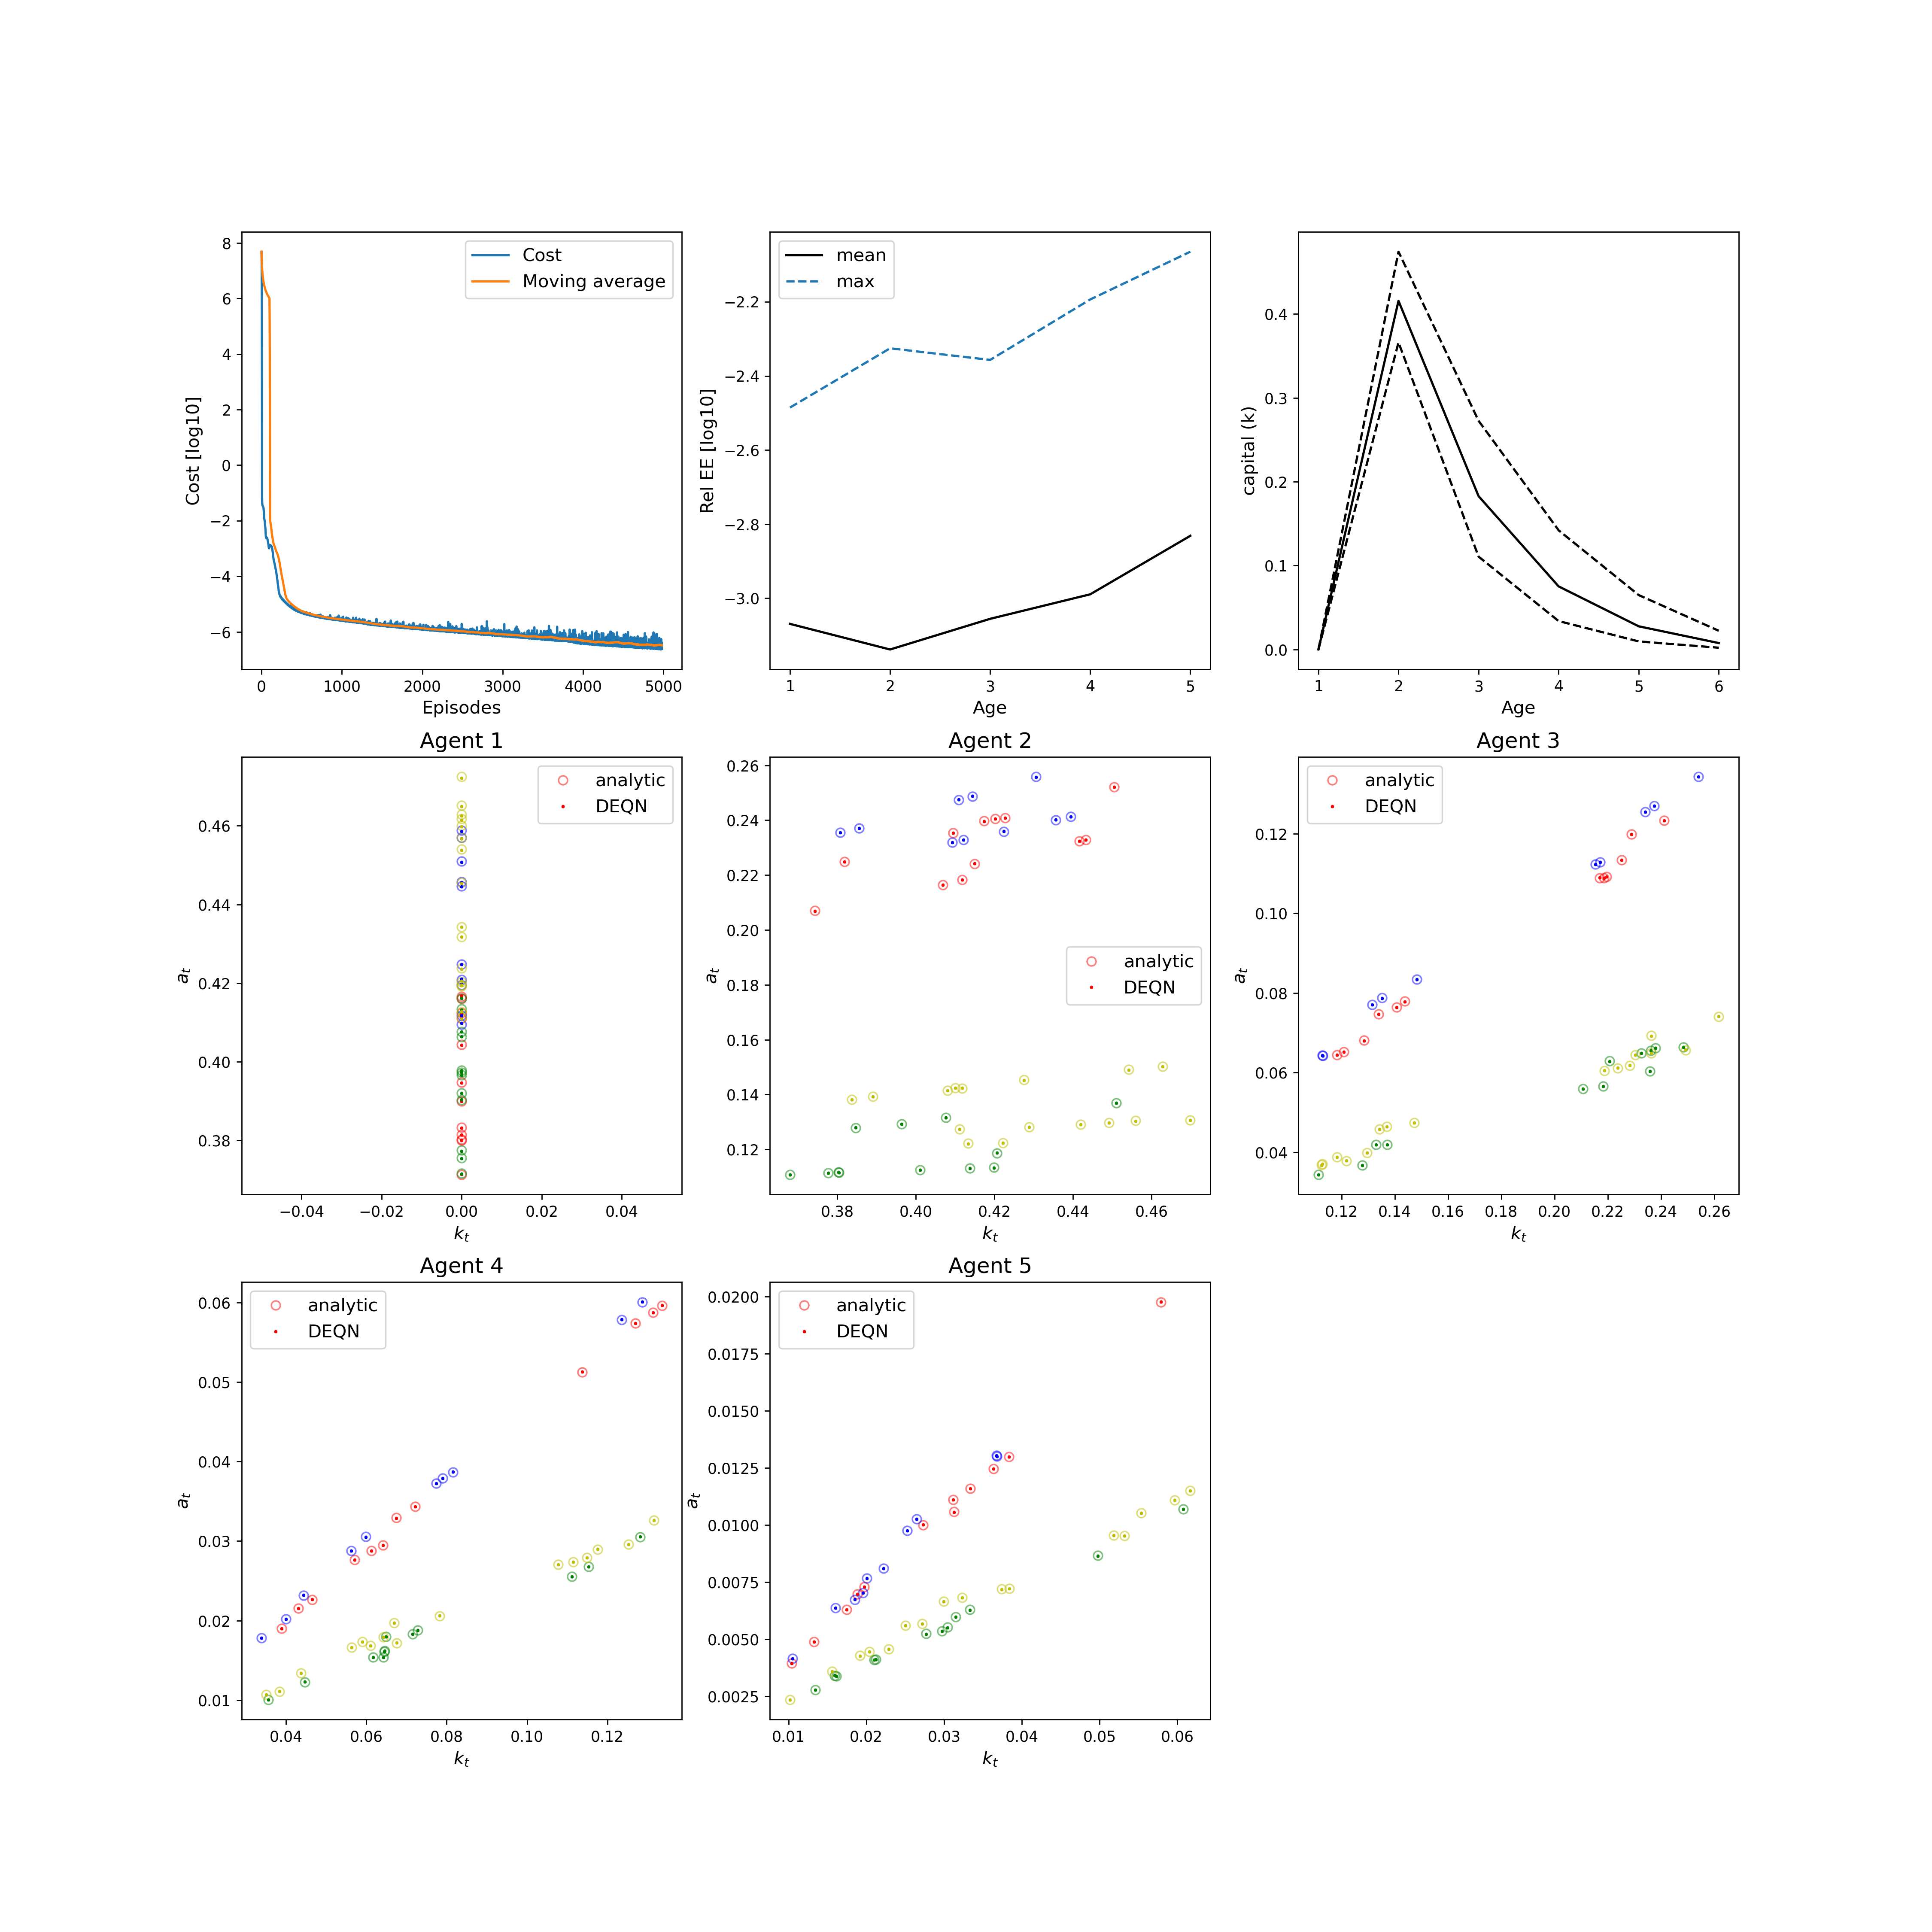

Calculated a valid starting point
start time: 2020-12-16 14:05:58.798942
Start simulating 10240 periods.
Finished simulation. Time for simulation: 0:00:02.938209.
Episode 0: log10(Cost): 7.6816; time: 14:06:05.761271; time since start: 0:00:06.962333
Episode 1: log10(Cost): 7.5046; time: 14:06:10.943807; time since start: 0:00:12.144872
Episode 2: log10(Cost): 7.2268; time: 14:06:15.686880; time since start: 0:00:16.887944
Episode 3: log10(Cost): 6.6636; time: 14:06:20.426902; time since start: 0:00:21.627967
Episode 4: log10(Cost): 5.8305; time: 14:06:25.154981; time since start: 0:00:26.356045
Episode 5: log10(Cost): 4.1767; time: 14:06:29.770392; time since start: 0:00:30.971457
Episode 6: log10(Cost): 2.4557; time: 14:06:34.306427; time since start: 0:00:35.507492
Episode 7: log10(Cost): -1.1944; time: 14:06:38.822985; time since start: 0:00:40.024050
Episode 8: log10(Cost): -1.3223; time: 14:06:43.334476; time since start: 0:00:44.535541
Episode 9: log10(Cost): -1.3889; time: 14:0

Episode 90: log10(Cost): -2.9557; time: 14:13:01.833804; time since start: 0:07:03.034869
Episode 91: log10(Cost): -2.9760; time: 14:13:06.214518; time since start: 0:07:07.415583
Episode 92: log10(Cost): -2.9854; time: 14:13:10.564472; time since start: 0:07:11.765536
Episode 93: log10(Cost): -2.9870; time: 14:13:14.863240; time since start: 0:07:16.064305
Episode 94: log10(Cost): -2.9922; time: 14:13:19.166831; time since start: 0:07:20.367895
Episode 95: log10(Cost): -2.9794; time: 14:13:23.496747; time since start: 0:07:24.697812
Episode 96: log10(Cost): -2.9622; time: 14:13:27.945768; time since start: 0:07:29.146833
Episode 97: log10(Cost): -2.9473; time: 14:13:32.349215; time since start: 0:07:33.550279
Episode 98: log10(Cost): -2.9281; time: 14:13:36.660100; time since start: 0:07:37.861165
Episode 99: log10(Cost): -2.9179; time: 14:13:40.994726; time since start: 0:07:42.195790
Episode 100: log10(Cost): -2.9080; time: 14:13:46.050821; time since start: 0:07:47.251883
Episode 1

Episode 181: log10(Cost): -3.8182; time: 14:19:45.660492; time since start: 0:13:46.861556
Episode 182: log10(Cost): -3.8301; time: 14:19:49.950016; time since start: 0:13:51.151080
Episode 183: log10(Cost): -3.8507; time: 14:19:54.231081; time since start: 0:13:55.432145
Episode 184: log10(Cost): -3.8632; time: 14:19:58.528549; time since start: 0:13:59.729614
Episode 185: log10(Cost): -3.8903; time: 14:20:02.980486; time since start: 0:14:04.181550
Episode 186: log10(Cost): -3.9031; time: 14:20:07.668613; time since start: 0:14:08.869676
Episode 187: log10(Cost): -3.9207; time: 14:20:12.583920; time since start: 0:14:13.784985
Episode 188: log10(Cost): -3.9411; time: 14:20:17.281148; time since start: 0:14:18.482213
Episode 189: log10(Cost): -3.9592; time: 14:20:21.822507; time since start: 0:14:23.023572
Episode 190: log10(Cost): -3.9806; time: 14:20:26.250943; time since start: 0:14:27.452008
Episode 191: log10(Cost): -3.9998; time: 14:20:30.573937; time since start: 0:14:31.775002

Episode 272: log10(Cost): -4.8680; time: 14:26:35.158109; time since start: 0:20:36.359173
Episode 273: log10(Cost): -4.8605; time: 14:26:39.598694; time since start: 0:20:40.799759
Episode 274: log10(Cost): -4.8637; time: 14:26:44.011693; time since start: 0:20:45.212757
Episode 275: log10(Cost): -4.8804; time: 14:26:48.486114; time since start: 0:20:49.687179
Episode 276: log10(Cost): -4.8845; time: 14:26:53.038048; time since start: 0:20:54.239114
Episode 277: log10(Cost): -4.8778; time: 14:26:57.616114; time since start: 0:20:58.817179
Episode 278: log10(Cost): -4.8868; time: 14:27:02.187825; time since start: 0:21:03.388889
Episode 279: log10(Cost): -4.8676; time: 14:27:06.718289; time since start: 0:21:07.919354
Episode 280: log10(Cost): -4.8950; time: 14:27:11.909412; time since start: 0:21:13.110475
Episode 281: log10(Cost): -4.8963; time: 14:27:16.277434; time since start: 0:21:17.478499
Episode 282: log10(Cost): -4.8908; time: 14:27:20.727670; time since start: 0:21:21.928734

Episode 363: log10(Cost): -5.0785; time: 14:33:27.251651; time since start: 0:27:28.452716
Episode 364: log10(Cost): -5.0916; time: 14:33:31.841731; time since start: 0:27:33.042797
Episode 365: log10(Cost): -5.1137; time: 14:33:36.339209; time since start: 0:27:37.540275
Episode 366: log10(Cost): -5.1093; time: 14:33:40.764731; time since start: 0:27:41.965796
Episode 367: log10(Cost): -5.1122; time: 14:33:45.190567; time since start: 0:27:46.391632
Episode 368: log10(Cost): -5.1115; time: 14:33:49.637342; time since start: 0:27:50.838407
Episode 369: log10(Cost): -5.1264; time: 14:33:54.125054; time since start: 0:27:55.326118
Episode 370: log10(Cost): -5.1219; time: 14:33:58.550084; time since start: 0:27:59.751149
Episode 371: log10(Cost): -5.1303; time: 14:34:03.073413; time since start: 0:28:04.274478
Episode 372: log10(Cost): -5.1310; time: 14:34:07.466033; time since start: 0:28:08.667098
Episode 373: log10(Cost): -5.1275; time: 14:34:11.949297; time since start: 0:28:13.150362

Episode 454: log10(Cost): -5.2681; time: 14:40:19.993810; time since start: 0:34:21.194875
Episode 455: log10(Cost): -5.2688; time: 14:40:24.453963; time since start: 0:34:25.655028
Episode 456: log10(Cost): -5.2614; time: 14:40:28.854125; time since start: 0:34:30.055189
Episode 457: log10(Cost): -5.2729; time: 14:40:33.404113; time since start: 0:34:34.605177
Episode 458: log10(Cost): -5.2663; time: 14:40:37.919874; time since start: 0:34:39.120939
Episode 459: log10(Cost): -5.2417; time: 14:40:42.641352; time since start: 0:34:43.842417
Episode 460: log10(Cost): -5.2602; time: 14:40:48.029161; time since start: 0:34:49.230223
Episode 461: log10(Cost): -5.2651; time: 14:40:52.438756; time since start: 0:34:53.639820
Episode 462: log10(Cost): -5.2660; time: 14:40:56.868890; time since start: 0:34:58.069956
Episode 463: log10(Cost): -5.2783; time: 14:41:01.429263; time since start: 0:35:02.630329
Episode 464: log10(Cost): -5.2733; time: 14:41:05.835915; time since start: 0:35:07.036980

Episode 541: log10(Cost): -5.3371; time: 14:47:14.311976; time since start: 0:41:15.513041
Episode 542: log10(Cost): -5.3651; time: 14:47:19.060577; time since start: 0:41:20.261642
Episode 543: log10(Cost): -5.3535; time: 14:47:23.838389; time since start: 0:41:25.039455
Episode 544: log10(Cost): -5.3608; time: 14:47:28.721040; time since start: 0:41:29.922105
Episode 545: log10(Cost): -5.3064; time: 14:47:33.515529; time since start: 0:41:34.716594
Episode 546: log10(Cost): -5.3463; time: 14:47:38.198372; time since start: 0:41:39.399437
Episode 547: log10(Cost): -5.3567; time: 14:47:42.778963; time since start: 0:41:43.980028
Episode 548: log10(Cost): -5.3497; time: 14:47:47.465721; time since start: 0:41:48.666786
Episode 549: log10(Cost): -5.3443; time: 14:47:52.026779; time since start: 0:41:53.227843
Episode 550: log10(Cost): -5.3377; time: 14:47:56.585748; time since start: 0:41:57.786813
Episode 551: log10(Cost): -5.3274; time: 14:48:01.086206; time since start: 0:42:02.287271

Episode 632: log10(Cost): -5.4168; time: 14:56:53.232430; time since start: 0:50:54.433495
Episode 633: log10(Cost): -5.4220; time: 14:56:59.259030; time since start: 0:51:00.460095
Episode 634: log10(Cost): -5.3847; time: 14:57:05.503926; time since start: 0:51:06.704991
Episode 635: log10(Cost): -5.4157; time: 14:57:12.500150; time since start: 0:51:13.701216
Episode 636: log10(Cost): -5.4027; time: 14:57:18.802286; time since start: 0:51:20.003351
Episode 637: log10(Cost): -5.3719; time: 14:57:25.552790; time since start: 0:51:26.753855
Episode 638: log10(Cost): -5.4015; time: 14:57:32.150211; time since start: 0:51:33.351275
Episode 639: log10(Cost): -5.4232; time: 14:57:38.945462; time since start: 0:51:40.146527
Episode 640: log10(Cost): -5.4065; time: 14:57:46.046767; time since start: 0:51:47.247832
Episode 641: log10(Cost): -5.3954; time: 14:57:51.731556; time since start: 0:51:52.932621
Episode 642: log10(Cost): -5.4301; time: 14:57:58.068786; time since start: 0:51:59.269853

Episode 723: log10(Cost): -5.4582; time: 15:04:48.039835; time since start: 0:58:49.240900
Episode 724: log10(Cost): -5.3995; time: 15:04:52.705273; time since start: 0:58:53.906338
Episode 725: log10(Cost): -5.4687; time: 15:04:57.516995; time since start: 0:58:58.718059
Episode 726: log10(Cost): -5.4697; time: 15:05:02.345303; time since start: 0:59:03.546368
Episode 727: log10(Cost): -5.4572; time: 15:05:07.389743; time since start: 0:59:08.590808
Episode 728: log10(Cost): -5.4490; time: 15:05:12.316090; time since start: 0:59:13.517155
Episode 729: log10(Cost): -5.4774; time: 15:05:17.074761; time since start: 0:59:18.275826
Episode 730: log10(Cost): -5.4395; time: 15:05:21.883113; time since start: 0:59:23.084178
Episode 731: log10(Cost): -5.3994; time: 15:05:26.855204; time since start: 0:59:28.056268
Episode 732: log10(Cost): -5.4890; time: 15:05:32.051918; time since start: 0:59:33.252983
Episode 733: log10(Cost): -5.4693; time: 15:05:37.060931; time since start: 0:59:38.261996

Episode 814: log10(Cost): -5.4990; time: 15:12:16.211878; time since start: 1:06:17.412943
Episode 815: log10(Cost): -5.5062; time: 15:12:21.181220; time since start: 1:06:22.382285
Episode 816: log10(Cost): -5.5181; time: 15:12:26.375345; time since start: 1:06:27.576411
Episode 817: log10(Cost): -5.4922; time: 15:12:31.636414; time since start: 1:06:32.837479
Episode 818: log10(Cost): -5.5225; time: 15:12:36.783817; time since start: 1:06:37.984883
Episode 819: log10(Cost): -5.4725; time: 15:12:41.979931; time since start: 1:06:43.180996
Episode 820: log10(Cost): -5.5181; time: 15:12:47.673613; time since start: 1:06:48.874675
Episode 821: log10(Cost): -5.5236; time: 15:12:52.410347; time since start: 1:06:53.611412
Episode 822: log10(Cost): -5.5182; time: 15:12:57.117770; time since start: 1:06:58.318835
Episode 823: log10(Cost): -5.5033; time: 15:13:01.955899; time since start: 1:07:03.156964
Episode 824: log10(Cost): -5.5201; time: 15:13:06.673062; time since start: 1:07:07.874126

Episode 905: log10(Cost): -5.5287; time: 15:19:55.107211; time since start: 1:13:56.308276
Episode 906: log10(Cost): -5.5653; time: 15:19:59.951457; time since start: 1:14:01.152522
Episode 907: log10(Cost): -5.5230; time: 15:20:04.832269; time since start: 1:14:06.033333
Episode 908: log10(Cost): -5.5537; time: 15:20:09.410344; time since start: 1:14:10.611409
Episode 909: log10(Cost): -5.5478; time: 15:20:14.080751; time since start: 1:14:15.281815
Episode 910: log10(Cost): -5.4898; time: 15:20:19.082324; time since start: 1:14:20.283389
Episode 911: log10(Cost): -5.5546; time: 15:20:24.634742; time since start: 1:14:25.835807
Episode 912: log10(Cost): -5.5402; time: 15:20:31.171394; time since start: 1:14:32.372459
Episode 913: log10(Cost): -5.5595; time: 15:20:36.765535; time since start: 1:14:37.966600
Episode 914: log10(Cost): -5.5591; time: 15:20:42.375577; time since start: 1:14:43.576643
Episode 915: log10(Cost): -5.5580; time: 15:20:48.368631; time since start: 1:14:49.569696

Episode 996: log10(Cost): -5.5901; time: 15:28:11.733936; time since start: 1:22:12.935001
Episode 997: log10(Cost): -5.5938; time: 15:28:17.565598; time since start: 1:22:18.766664
Episode 998: log10(Cost): -5.5951; time: 15:28:23.273025; time since start: 1:22:24.474090
Episode 999: log10(Cost): -5.5895; time: 15:28:29.159897; time since start: 1:22:30.360961
Episode 1000: log10(Cost): -5.5567; time: 15:28:35.468244; time since start: 1:22:36.669307
Episode 1001: log10(Cost): -5.5839; time: 15:28:41.582279; time since start: 1:22:42.783349
Episode 1002: log10(Cost): -5.5544; time: 15:28:47.124851; time since start: 1:22:48.325917
Episode 1003: log10(Cost): -5.5895; time: 15:28:52.423573; time since start: 1:22:53.624639
Episode 1004: log10(Cost): -5.5939; time: 15:28:57.847609; time since start: 1:22:59.048674
Episode 1005: log10(Cost): -5.5715; time: 15:29:03.298974; time since start: 1:23:04.500039
Episode 1006: log10(Cost): -5.5936; time: 15:29:08.604761; time since start: 1:23:09

Episode 1086: log10(Cost): -5.6218; time: 15:36:27.767387; time since start: 1:30:28.968453
Episode 1087: log10(Cost): -5.6255; time: 15:36:33.079096; time since start: 1:30:34.280162
Episode 1088: log10(Cost): -5.6352; time: 15:36:38.360832; time since start: 1:30:39.561897
Episode 1089: log10(Cost): -5.5770; time: 15:36:43.563218; time since start: 1:30:44.764283
Episode 1090: log10(Cost): -5.5637; time: 15:36:48.595809; time since start: 1:30:49.796874
Episode 1091: log10(Cost): -5.6309; time: 15:36:53.840754; time since start: 1:30:55.041819
Episode 1092: log10(Cost): -5.6296; time: 15:36:59.183027; time since start: 1:31:00.384092
Episode 1093: log10(Cost): -5.5268; time: 15:37:04.858341; time since start: 1:31:06.059408
Episode 1094: log10(Cost): -5.6191; time: 15:37:10.959751; time since start: 1:31:12.160817
Episode 1095: log10(Cost): -5.6284; time: 15:37:17.607235; time since start: 1:31:18.808301
Episode 1096: log10(Cost): -5.6209; time: 15:37:23.129731; time since start: 1:3

Episode 1176: log10(Cost): -5.6105; time: 15:44:25.438351; time since start: 1:38:26.639416
Episode 1177: log10(Cost): -5.4901; time: 15:44:31.148127; time since start: 1:38:32.349192
Episode 1178: log10(Cost): -5.5740; time: 15:44:36.755250; time since start: 1:38:37.956315
Episode 1179: log10(Cost): -5.6638; time: 15:44:42.018975; time since start: 1:38:43.220040
Episode 1180: log10(Cost): -5.6093; time: 15:44:48.445221; time since start: 1:38:49.646284
Episode 1181: log10(Cost): -5.6486; time: 15:44:54.024553; time since start: 1:38:55.225618
Episode 1182: log10(Cost): -5.6587; time: 15:44:59.522975; time since start: 1:39:00.724040
Episode 1183: log10(Cost): -5.6378; time: 15:45:05.021885; time since start: 1:39:06.222950
Episode 1184: log10(Cost): -5.6603; time: 15:45:10.646133; time since start: 1:39:11.847198
Episode 1185: log10(Cost): -5.6493; time: 15:45:16.237895; time since start: 1:39:17.438959
Episode 1186: log10(Cost): -5.6675; time: 15:45:21.539780; time since start: 1:3

Episode 1266: log10(Cost): -5.6543; time: 15:52:04.215807; time since start: 1:46:05.416872
Episode 1267: log10(Cost): -5.6975; time: 15:52:08.714774; time since start: 1:46:09.915839
Episode 1268: log10(Cost): -5.6781; time: 15:52:13.299426; time since start: 1:46:14.500491
Episode 1269: log10(Cost): -5.6951; time: 15:52:17.879320; time since start: 1:46:19.080385
Episode 1270: log10(Cost): -5.6787; time: 15:52:22.449638; time since start: 1:46:23.650703
Episode 1271: log10(Cost): -5.6186; time: 15:52:27.209660; time since start: 1:46:28.410725
Episode 1272: log10(Cost): -5.6901; time: 15:52:31.939566; time since start: 1:46:33.140630
Episode 1273: log10(Cost): -5.6845; time: 15:52:36.704397; time since start: 1:46:37.905462
Episode 1274: log10(Cost): -5.6695; time: 15:52:41.513898; time since start: 1:46:42.714962
Episode 1275: log10(Cost): -5.6944; time: 15:52:46.204008; time since start: 1:46:47.405072
Episode 1276: log10(Cost): -5.6209; time: 15:52:50.949805; time since start: 1:4

Episode 1356: log10(Cost): -5.7105; time: 15:59:34.368127; time since start: 1:53:35.569191
Episode 1357: log10(Cost): -5.7229; time: 15:59:39.425060; time since start: 1:53:40.626125
Episode 1358: log10(Cost): -5.7149; time: 15:59:44.671568; time since start: 1:53:45.872633
Episode 1359: log10(Cost): -5.7154; time: 15:59:49.365709; time since start: 1:53:50.566774
Episode 1360: log10(Cost): -5.7417; time: 15:59:54.919637; time since start: 1:53:56.120699
Episode 1361: log10(Cost): -5.7368; time: 16:00:00.485714; time since start: 1:54:01.686778
Episode 1362: log10(Cost): -5.6904; time: 16:00:05.575466; time since start: 1:54:06.776531
Episode 1363: log10(Cost): -5.7426; time: 16:00:10.671195; time since start: 1:54:11.872261
Episode 1364: log10(Cost): -5.7317; time: 16:00:15.595997; time since start: 1:54:16.797062
Episode 1365: log10(Cost): -5.7282; time: 16:00:20.923379; time since start: 1:54:22.124444
Episode 1366: log10(Cost): -5.7023; time: 16:00:25.831367; time since start: 1:5

Episode 1446: log10(Cost): -5.7614; time: 16:06:43.592335; time since start: 2:00:44.793399
Episode 1447: log10(Cost): -5.7264; time: 16:06:48.176042; time since start: 2:00:49.377106
Episode 1448: log10(Cost): -5.7618; time: 16:06:52.625046; time since start: 2:00:53.826111
Episode 1449: log10(Cost): -5.7487; time: 16:06:57.050892; time since start: 2:00:58.251957
Episode 1450: log10(Cost): -5.7375; time: 16:07:01.615988; time since start: 2:01:02.817052
Episode 1451: log10(Cost): -5.7535; time: 16:07:06.104575; time since start: 2:01:07.305640
Episode 1452: log10(Cost): -5.7422; time: 16:07:10.539939; time since start: 2:01:11.741004
Episode 1453: log10(Cost): -5.7628; time: 16:07:15.089092; time since start: 2:01:16.290156
Episode 1454: log10(Cost): -5.7086; time: 16:07:19.724944; time since start: 2:01:20.926009
Episode 1455: log10(Cost): -5.7558; time: 16:07:24.302814; time since start: 2:01:25.503879
Episode 1456: log10(Cost): -5.7653; time: 16:07:28.970890; time since start: 2:0

Episode 1536: log10(Cost): -5.7170; time: 16:13:54.644979; time since start: 2:07:55.846043
Episode 1537: log10(Cost): -5.6273; time: 16:13:59.229990; time since start: 2:08:00.431055
Episode 1538: log10(Cost): -5.7744; time: 16:14:03.941810; time since start: 2:08:05.142874
Episode 1539: log10(Cost): -5.7424; time: 16:14:08.653602; time since start: 2:08:09.854667
Episode 1540: log10(Cost): -5.7706; time: 16:14:14.389613; time since start: 2:08:15.590677
Episode 1541: log10(Cost): -5.7447; time: 16:14:19.668240; time since start: 2:08:20.869305
Episode 1542: log10(Cost): -5.7722; time: 16:14:24.780412; time since start: 2:08:25.981477
Episode 1543: log10(Cost): -5.7358; time: 16:14:30.140489; time since start: 2:08:31.341554
Episode 1544: log10(Cost): -5.7326; time: 16:14:35.889894; time since start: 2:08:37.090959
Episode 1545: log10(Cost): -5.7907; time: 16:14:42.466008; time since start: 2:08:43.667073
Episode 1546: log10(Cost): -5.7183; time: 16:14:48.388797; time since start: 2:0

Episode 1626: log10(Cost): -5.7845; time: 16:21:31.696218; time since start: 2:15:32.897283
Episode 1627: log10(Cost): -5.7795; time: 16:21:36.809808; time since start: 2:15:38.010873
Episode 1628: log10(Cost): -5.8168; time: 16:21:41.657283; time since start: 2:15:42.858348
Episode 1629: log10(Cost): -5.7960; time: 16:21:46.359511; time since start: 2:15:47.560576
Episode 1630: log10(Cost): -5.7569; time: 16:21:51.022767; time since start: 2:15:52.223832
Episode 1631: log10(Cost): -5.8180; time: 16:21:55.713424; time since start: 2:15:56.914489
Episode 1632: log10(Cost): -5.7366; time: 16:22:00.484806; time since start: 2:16:01.685871
Episode 1633: log10(Cost): -5.8151; time: 16:22:05.400677; time since start: 2:16:06.601742
Episode 1634: log10(Cost): -5.8217; time: 16:22:10.388260; time since start: 2:16:11.589324
Episode 1635: log10(Cost): -5.8201; time: 16:22:15.649754; time since start: 2:16:16.850819
Episode 1636: log10(Cost): -5.7783; time: 16:22:20.971311; time since start: 2:1

Episode 1716: log10(Cost): -5.7131; time: 16:29:07.122476; time since start: 2:23:08.323541
Episode 1717: log10(Cost): -5.6980; time: 16:29:11.998044; time since start: 2:23:13.199109
Episode 1718: log10(Cost): -5.8148; time: 16:29:16.895723; time since start: 2:23:18.096789
Episode 1719: log10(Cost): -5.8480; time: 16:29:21.838162; time since start: 2:23:23.039226
Episode 1720: log10(Cost): -5.8438; time: 16:29:27.568946; time since start: 2:23:28.770008
Episode 1721: log10(Cost): -5.8509; time: 16:29:32.321950; time since start: 2:23:33.523015
Episode 1722: log10(Cost): -5.6986; time: 16:29:36.960009; time since start: 2:23:38.161073
Episode 1723: log10(Cost): -5.8155; time: 16:29:41.628704; time since start: 2:23:42.829769
Episode 1724: log10(Cost): -5.7322; time: 16:29:46.389755; time since start: 2:23:47.590820
Episode 1725: log10(Cost): -5.8021; time: 16:29:51.252279; time since start: 2:23:52.453344
Episode 1726: log10(Cost): -5.8385; time: 16:29:56.047296; time since start: 2:2

Episode 1806: log10(Cost): -5.8673; time: 16:36:37.274140; time since start: 2:30:38.475204
Episode 1807: log10(Cost): -5.8617; time: 16:36:41.926656; time since start: 2:30:43.127721
Episode 1808: log10(Cost): -5.8085; time: 16:36:46.509720; time since start: 2:30:47.710785
Episode 1809: log10(Cost): -5.8060; time: 16:36:51.095341; time since start: 2:30:52.296406
Episode 1810: log10(Cost): -5.8377; time: 16:36:55.619106; time since start: 2:30:56.820171
Episode 1811: log10(Cost): -5.8602; time: 16:37:00.058873; time since start: 2:31:01.259938
Episode 1812: log10(Cost): -5.8421; time: 16:37:04.583948; time since start: 2:31:05.785013
Episode 1813: log10(Cost): -5.8173; time: 16:37:09.029673; time since start: 2:31:10.230738
Episode 1814: log10(Cost): -5.8531; time: 16:37:13.481182; time since start: 2:31:14.682247
Episode 1815: log10(Cost): -5.8075; time: 16:37:18.050003; time since start: 2:31:19.251068
Episode 1816: log10(Cost): -5.8258; time: 16:37:22.730100; time since start: 2:3

Episode 1896: log10(Cost): -5.8866; time: 16:43:36.164911; time since start: 2:37:37.365976
Episode 1897: log10(Cost): -5.8816; time: 16:43:41.119002; time since start: 2:37:42.320067
Episode 1898: log10(Cost): -5.8821; time: 16:43:46.063342; time since start: 2:37:47.264407
Episode 1899: log10(Cost): -5.8578; time: 16:43:50.841847; time since start: 2:37:52.042912
Episode 1900: log10(Cost): -5.8865; time: 16:43:56.620289; time since start: 2:37:57.821352
Episode 1901: log10(Cost): -5.8156; time: 16:44:01.766261; time since start: 2:38:02.967325
Episode 1902: log10(Cost): -5.8511; time: 16:44:06.564393; time since start: 2:38:07.765458
Episode 1903: log10(Cost): -5.8728; time: 16:44:11.803647; time since start: 2:38:13.004713
Episode 1904: log10(Cost): -5.8757; time: 16:44:17.276418; time since start: 2:38:18.477484
Episode 1905: log10(Cost): -5.8693; time: 16:44:22.544274; time since start: 2:38:23.745339
Episode 1906: log10(Cost): -5.8538; time: 16:44:27.664384; time since start: 2:3

Episode 1986: log10(Cost): -5.8972; time: 16:51:04.195153; time since start: 2:45:05.396218
Episode 1987: log10(Cost): -5.9129; time: 16:51:09.167904; time since start: 2:45:10.368969
Episode 1988: log10(Cost): -5.9101; time: 16:51:14.381160; time since start: 2:45:15.582224
Episode 1989: log10(Cost): -5.8657; time: 16:51:19.576277; time since start: 2:45:20.777343
Episode 1990: log10(Cost): -5.9061; time: 16:51:24.545332; time since start: 2:45:25.746397
Episode 1991: log10(Cost): -5.9000; time: 16:51:29.439775; time since start: 2:45:30.640840
Episode 1992: log10(Cost): -5.9045; time: 16:51:34.238171; time since start: 2:45:35.439235
Episode 1993: log10(Cost): -5.9067; time: 16:51:38.903214; time since start: 2:45:40.104279
Episode 1994: log10(Cost): -5.8985; time: 16:51:43.464121; time since start: 2:45:44.665186
Episode 1995: log10(Cost): -5.8376; time: 16:51:48.092047; time since start: 2:45:49.293113
Episode 1996: log10(Cost): -5.8952; time: 16:51:52.946934; time since start: 2:4

Episode 2076: log10(Cost): -5.9331; time: 16:58:12.815933; time since start: 2:52:14.016998
Episode 2077: log10(Cost): -5.9065; time: 16:58:17.474283; time since start: 2:52:18.675347
Episode 2078: log10(Cost): -5.9154; time: 16:58:22.084836; time since start: 2:52:23.285900
Episode 2079: log10(Cost): -5.9178; time: 16:58:26.855795; time since start: 2:52:28.056860
Episode 2080: log10(Cost): -5.8654; time: 16:58:32.559047; time since start: 2:52:33.760110
Episode 2081: log10(Cost): -5.9225; time: 16:58:37.249642; time since start: 2:52:38.450707
Episode 2082: log10(Cost): -5.8804; time: 16:58:41.809757; time since start: 2:52:43.010822
Episode 2083: log10(Cost): -5.8268; time: 16:58:46.259147; time since start: 2:52:47.460211
Episode 2084: log10(Cost): -5.9283; time: 16:58:50.702479; time since start: 2:52:51.903544
Episode 2085: log10(Cost): -5.9338; time: 16:58:55.286901; time since start: 2:52:56.487966
Episode 2086: log10(Cost): -5.9389; time: 16:58:59.871191; time since start: 2:5

Episode 2166: log10(Cost): -5.9357; time: 17:05:10.116230; time since start: 2:59:11.317294
Episode 2167: log10(Cost): -5.9354; time: 17:05:14.496882; time since start: 2:59:15.697947
Episode 2168: log10(Cost): -5.9513; time: 17:05:18.931462; time since start: 2:59:20.132527
Episode 2169: log10(Cost): -5.9591; time: 17:05:23.477356; time since start: 2:59:24.678421
Episode 2170: log10(Cost): -5.8559; time: 17:05:28.062589; time since start: 2:59:29.263654
Episode 2171: log10(Cost): -5.9521; time: 17:05:32.779882; time since start: 2:59:33.980947
Episode 2172: log10(Cost): -5.9434; time: 17:05:37.533407; time since start: 2:59:38.734472
Episode 2173: log10(Cost): -5.8967; time: 17:05:42.146656; time since start: 2:59:43.347721
Episode 2174: log10(Cost): -5.9402; time: 17:05:46.699044; time since start: 2:59:47.900108
Episode 2175: log10(Cost): -5.8734; time: 17:05:51.359061; time since start: 2:59:52.560125
Episode 2176: log10(Cost): -5.9610; time: 17:05:55.923593; time since start: 2:5

Episode 2256: log10(Cost): -5.9705; time: 17:12:07.516520; time since start: 3:06:08.717585
Episode 2257: log10(Cost): -5.9677; time: 17:12:11.961844; time since start: 3:06:13.162909
Episode 2258: log10(Cost): -5.9634; time: 17:12:16.593232; time since start: 3:06:17.794297
Episode 2259: log10(Cost): -5.9695; time: 17:12:21.251080; time since start: 3:06:22.452144
Episode 2260: log10(Cost): -5.8576; time: 17:12:26.976040; time since start: 3:06:28.177102
Episode 2261: log10(Cost): -5.9043; time: 17:12:31.901534; time since start: 3:06:33.102599
Episode 2262: log10(Cost): -5.9752; time: 17:12:36.555662; time since start: 3:06:37.756726
Episode 2263: log10(Cost): -5.9762; time: 17:12:41.144780; time since start: 3:06:42.345845
Episode 2264: log10(Cost): -5.9665; time: 17:12:45.668238; time since start: 3:06:46.869303
Episode 2265: log10(Cost): -5.9405; time: 17:12:50.171951; time since start: 3:06:51.373016
Episode 2266: log10(Cost): -5.9666; time: 17:12:54.610430; time since start: 3:0

Episode 2346: log10(Cost): -5.9336; time: 17:19:06.687183; time since start: 3:13:07.888247
Episode 2347: log10(Cost): -5.7164; time: 17:19:11.315360; time since start: 3:13:12.516424
Episode 2348: log10(Cost): -5.9647; time: 17:19:15.877133; time since start: 3:13:17.078198
Episode 2349: log10(Cost): -5.9877; time: 17:19:20.465475; time since start: 3:13:21.666540
Episode 2350: log10(Cost): -6.0000; time: 17:19:25.186161; time since start: 3:13:26.387226
Episode 2351: log10(Cost): -5.9959; time: 17:19:29.894500; time since start: 3:13:31.095564
Episode 2352: log10(Cost): -5.9992; time: 17:19:34.519029; time since start: 3:13:35.720094
Episode 2353: log10(Cost): -5.9864; time: 17:19:39.098205; time since start: 3:13:40.299269
Episode 2354: log10(Cost): -6.0022; time: 17:19:43.653280; time since start: 3:13:44.854345
Episode 2355: log10(Cost): -5.9971; time: 17:19:48.144644; time since start: 3:13:49.345709
Episode 2356: log10(Cost): -5.9921; time: 17:19:52.578757; time since start: 3:1

Episode 2436: log10(Cost): -5.9540; time: 17:26:03.018586; time since start: 3:20:04.219651
Episode 2437: log10(Cost): -5.9565; time: 17:26:07.619621; time since start: 3:20:08.820686
Episode 2438: log10(Cost): -5.9052; time: 17:26:12.179123; time since start: 3:20:13.380188
Episode 2439: log10(Cost): -6.0116; time: 17:26:16.751625; time since start: 3:20:17.952690
Episode 2440: log10(Cost): -5.9910; time: 17:26:22.108248; time since start: 3:20:23.309310
Episode 2441: log10(Cost): -5.9631; time: 17:26:26.553267; time since start: 3:20:27.754332
Episode 2442: log10(Cost): -5.9560; time: 17:26:31.009942; time since start: 3:20:32.211007
Episode 2443: log10(Cost): -6.0150; time: 17:26:35.591929; time since start: 3:20:36.792993
Episode 2444: log10(Cost): -6.0098; time: 17:26:40.240796; time since start: 3:20:41.441861
Episode 2445: log10(Cost): -5.9546; time: 17:26:44.904241; time since start: 3:20:46.105305
Episode 2446: log10(Cost): -5.9234; time: 17:26:49.484485; time since start: 3:2

Episode 2526: log10(Cost): -5.9409; time: 17:33:12.373519; time since start: 3:27:13.574583
Episode 2527: log10(Cost): -6.0238; time: 17:33:17.122155; time since start: 3:27:18.323220
Episode 2528: log10(Cost): -6.0048; time: 17:33:21.858704; time since start: 3:27:23.059769
Episode 2529: log10(Cost): -6.0109; time: 17:33:26.616650; time since start: 3:27:27.817715
Episode 2530: log10(Cost): -5.9123; time: 17:33:31.424774; time since start: 3:27:32.625840
Episode 2531: log10(Cost): -6.0230; time: 17:33:36.339650; time since start: 3:27:37.540715
Episode 2532: log10(Cost): -6.0366; time: 17:33:41.346892; time since start: 3:27:42.547958
Episode 2533: log10(Cost): -6.0003; time: 17:33:46.159401; time since start: 3:27:47.360466
Episode 2534: log10(Cost): -6.0429; time: 17:33:50.816011; time since start: 3:27:52.017076
Episode 2535: log10(Cost): -6.0359; time: 17:33:55.420275; time since start: 3:27:56.621340
Episode 2536: log10(Cost): -6.0047; time: 17:34:00.041308; time since start: 3:2

Episode 2616: log10(Cost): -6.0599; time: 17:40:23.439986; time since start: 3:34:24.641051
Episode 2617: log10(Cost): -5.9618; time: 17:40:28.210579; time since start: 3:34:29.411644
Episode 2618: log10(Cost): -6.0650; time: 17:40:32.997626; time since start: 3:34:34.198691
Episode 2619: log10(Cost): -5.9179; time: 17:40:37.807392; time since start: 3:34:39.008457
Episode 2620: log10(Cost): -5.9842; time: 17:40:43.387642; time since start: 3:34:44.588704
Episode 2621: log10(Cost): -5.9737; time: 17:40:48.004077; time since start: 3:34:49.205142
Episode 2622: log10(Cost): -6.0366; time: 17:40:52.632176; time since start: 3:34:53.833241
Episode 2623: log10(Cost): -6.0142; time: 17:40:57.308926; time since start: 3:34:58.509991
Episode 2624: log10(Cost): -5.8782; time: 17:41:01.919871; time since start: 3:35:03.120936
Episode 2625: log10(Cost): -5.9973; time: 17:41:06.523366; time since start: 3:35:07.724431
Episode 2626: log10(Cost): -6.0521; time: 17:41:11.168449; time since start: 3:3

Episode 2706: log10(Cost): -6.0736; time: 17:47:35.487576; time since start: 3:41:36.688641
Episode 2707: log10(Cost): -6.0775; time: 17:47:40.185623; time since start: 3:41:41.386688
Episode 2708: log10(Cost): -6.0740; time: 17:47:44.793314; time since start: 3:41:45.994379
Episode 2709: log10(Cost): -6.0874; time: 17:47:49.402089; time since start: 3:41:50.603154
Episode 2710: log10(Cost): -6.0317; time: 17:47:53.905103; time since start: 3:41:55.106168
Episode 2711: log10(Cost): -6.0790; time: 17:47:58.546320; time since start: 3:41:59.747385
Episode 2712: log10(Cost): -6.0514; time: 17:48:03.314385; time since start: 3:42:04.515451
Episode 2713: log10(Cost): -6.0836; time: 17:48:08.107752; time since start: 3:42:09.308817
Episode 2714: log10(Cost): -6.0842; time: 17:48:12.773078; time since start: 3:42:13.974143
Episode 2715: log10(Cost): -5.9889; time: 17:48:17.567964; time since start: 3:42:18.769029
Episode 2716: log10(Cost): -5.9686; time: 17:48:22.473825; time since start: 3:4

Episode 2796: log10(Cost): -6.0077; time: 17:54:44.209025; time since start: 3:48:45.410091
Episode 2797: log10(Cost): -5.9301; time: 17:54:49.047533; time since start: 3:48:50.248598
Episode 2798: log10(Cost): -6.0858; time: 17:54:53.804387; time since start: 3:48:55.005452
Episode 2799: log10(Cost): -5.9586; time: 17:54:58.613452; time since start: 3:48:59.814517
Episode 2800: log10(Cost): -6.1020; time: 17:55:04.218930; time since start: 3:49:05.419993
Episode 2801: log10(Cost): -6.0562; time: 17:55:09.234885; time since start: 3:49:10.435950
Episode 2802: log10(Cost): -6.0354; time: 17:55:14.054195; time since start: 3:49:15.255260
Episode 2803: log10(Cost): -6.0965; time: 17:55:19.147008; time since start: 3:49:20.348073
Episode 2804: log10(Cost): -5.6172; time: 17:55:24.141918; time since start: 3:49:25.342983
Episode 2805: log10(Cost): -5.9041; time: 17:55:29.004288; time since start: 3:49:30.205354
Episode 2806: log10(Cost): -6.0867; time: 17:55:33.769930; time since start: 3:4

Episode 2886: log10(Cost): -6.0806; time: 18:01:53.412999; time since start: 3:55:54.614064
Episode 2887: log10(Cost): -6.0866; time: 18:01:58.125603; time since start: 3:55:59.326667
Episode 2888: log10(Cost): -5.9134; time: 18:02:02.776456; time since start: 3:56:03.977520
Episode 2889: log10(Cost): -6.0740; time: 18:02:07.529546; time since start: 3:56:08.730611
Episode 2890: log10(Cost): -6.1196; time: 18:02:12.365835; time since start: 3:56:13.566901
Episode 2891: log10(Cost): -5.9026; time: 18:02:17.171374; time since start: 3:56:18.372439
Episode 2892: log10(Cost): -6.0836; time: 18:02:22.145985; time since start: 3:56:23.347050
Episode 2893: log10(Cost): -6.1263; time: 18:02:27.006272; time since start: 3:56:28.207337
Episode 2894: log10(Cost): -6.0980; time: 18:02:31.684443; time since start: 3:56:32.885507
Episode 2895: log10(Cost): -6.0027; time: 18:02:36.323881; time since start: 3:56:37.524946
Episode 2896: log10(Cost): -6.1199; time: 18:02:40.958649; time since start: 3:5

Episode 2976: log10(Cost): -6.1383; time: 18:09:03.757292; time since start: 4:03:04.958357
Episode 2977: log10(Cost): -5.9355; time: 18:09:08.414719; time since start: 4:03:09.615785
Episode 2978: log10(Cost): -6.1296; time: 18:09:13.216241; time since start: 4:03:14.417306
Episode 2979: log10(Cost): -6.1154; time: 18:09:18.003948; time since start: 4:03:19.205012
Episode 2980: log10(Cost): -6.0538; time: 18:09:23.799831; time since start: 4:03:25.000893
Episode 2981: log10(Cost): -6.1390; time: 18:09:28.757467; time since start: 4:03:29.958532
Episode 2982: log10(Cost): -6.1189; time: 18:09:33.717114; time since start: 4:03:34.918179
Episode 2983: log10(Cost): -6.0482; time: 18:09:38.474196; time since start: 4:03:39.675261
Episode 2984: log10(Cost): -6.1278; time: 18:09:43.122177; time since start: 4:03:44.323242
Episode 2985: log10(Cost): -6.0793; time: 18:09:47.877991; time since start: 4:03:49.079057
Episode 2986: log10(Cost): -6.1386; time: 18:09:52.570176; time since start: 4:0

Episode 3066: log10(Cost): -6.0644; time: 18:16:15.022323; time since start: 4:10:16.223389
Episode 3067: log10(Cost): -6.1164; time: 18:16:19.841935; time since start: 4:10:21.043000
Episode 3068: log10(Cost): -6.0898; time: 18:16:24.798845; time since start: 4:10:25.999911
Episode 3069: log10(Cost): -5.9726; time: 18:16:29.730275; time since start: 4:10:30.931341
Episode 3070: log10(Cost): -6.1590; time: 18:16:34.538971; time since start: 4:10:35.740037
Episode 3071: log10(Cost): -6.1566; time: 18:16:39.303324; time since start: 4:10:40.504389
Episode 3072: log10(Cost): -6.1569; time: 18:16:44.061958; time since start: 4:10:45.263024
Episode 3073: log10(Cost): -5.9897; time: 18:16:48.817656; time since start: 4:10:50.018722
Episode 3074: log10(Cost): -6.1334; time: 18:16:53.508809; time since start: 4:10:54.709874
Episode 3075: log10(Cost): -6.1406; time: 18:16:58.138347; time since start: 4:10:59.339412
Episode 3076: log10(Cost): -6.1641; time: 18:17:02.786093; time since start: 4:1

Episode 3156: log10(Cost): -6.1806; time: 18:23:24.237878; time since start: 4:17:25.438943
Episode 3157: log10(Cost): -5.8790; time: 18:23:29.195997; time since start: 4:17:30.397062
Episode 3158: log10(Cost): -6.1839; time: 18:23:34.239906; time since start: 4:17:35.440971
Episode 3159: log10(Cost): -6.0656; time: 18:23:39.168267; time since start: 4:17:40.369332
Episode 3160: log10(Cost): -6.1855; time: 18:23:44.937044; time since start: 4:17:46.138107
Episode 3161: log10(Cost): -6.1333; time: 18:23:49.614463; time since start: 4:17:50.815527
Episode 3162: log10(Cost): -6.1950; time: 18:23:54.253069; time since start: 4:17:55.454134
Episode 3163: log10(Cost): -6.1762; time: 18:23:58.869086; time since start: 4:18:00.070151
Episode 3164: log10(Cost): -6.1728; time: 18:24:03.519744; time since start: 4:18:04.720809
Episode 3165: log10(Cost): -6.1409; time: 18:24:08.312482; time since start: 4:18:09.513546
Episode 3166: log10(Cost): -6.1219; time: 18:24:12.974427; time since start: 4:1

Episode 3246: log10(Cost): -6.1353; time: 18:30:33.687278; time since start: 4:24:34.888344
Episode 3247: log10(Cost): -6.1448; time: 18:30:38.379706; time since start: 4:24:39.580771
Episode 3248: log10(Cost): -6.1936; time: 18:30:42.963748; time since start: 4:24:44.164813
Episode 3249: log10(Cost): -6.1990; time: 18:30:47.714984; time since start: 4:24:48.916050
Episode 3250: log10(Cost): -6.2094; time: 18:30:52.398063; time since start: 4:24:53.599128
Episode 3251: log10(Cost): -6.2011; time: 18:30:57.120027; time since start: 4:24:58.321092
Episode 3252: log10(Cost): -6.1263; time: 18:31:01.761372; time since start: 4:25:02.962438
Episode 3253: log10(Cost): -6.0806; time: 18:31:06.312758; time since start: 4:25:07.513823
Episode 3254: log10(Cost): -6.1899; time: 18:31:10.946199; time since start: 4:25:12.147263
Episode 3255: log10(Cost): -6.2025; time: 18:31:15.455290; time since start: 4:25:16.656355
Episode 3256: log10(Cost): -6.1962; time: 18:31:19.904580; time since start: 4:2

Episode 3336: log10(Cost): -6.2148; time: 18:37:30.700818; time since start: 4:31:31.901882
Episode 3337: log10(Cost): -6.1409; time: 18:37:35.431609; time since start: 4:31:36.632674
Episode 3338: log10(Cost): -6.2079; time: 18:37:40.105466; time since start: 4:31:41.306531
Episode 3339: log10(Cost): -6.1886; time: 18:37:44.687885; time since start: 4:31:45.888950
Episode 3340: log10(Cost): -6.1706; time: 18:37:50.060600; time since start: 4:31:51.261662
Episode 3341: log10(Cost): -6.1764; time: 18:37:54.686166; time since start: 4:31:55.887231
Episode 3342: log10(Cost): -6.2211; time: 18:37:59.216187; time since start: 4:32:00.417253
Episode 3343: log10(Cost): -6.1165; time: 18:38:03.827267; time since start: 4:32:05.028332
Episode 3344: log10(Cost): -6.0748; time: 18:38:08.316976; time since start: 4:32:09.518041
Episode 3345: log10(Cost): -6.1742; time: 18:38:12.809723; time since start: 4:32:14.010788
Episode 3346: log10(Cost): -6.2301; time: 18:38:17.384227; time since start: 4:3

Episode 3426: log10(Cost): -5.9434; time: 18:44:28.984055; time since start: 4:38:30.185120
Episode 3427: log10(Cost): -6.2607; time: 18:44:33.586574; time since start: 4:38:34.787638
Episode 3428: log10(Cost): -6.2425; time: 18:44:38.229579; time since start: 4:38:39.430644
Episode 3429: log10(Cost): -6.2630; time: 18:44:42.828042; time since start: 4:38:44.029106
Episode 3430: log10(Cost): -6.2541; time: 18:44:47.406424; time since start: 4:38:48.607489
Episode 3431: log10(Cost): -6.2152; time: 18:44:51.975431; time since start: 4:38:53.176496
Episode 3432: log10(Cost): -6.1477; time: 18:44:56.542453; time since start: 4:38:57.743517
Episode 3433: log10(Cost): -6.1005; time: 18:45:01.183551; time since start: 4:39:02.384615
Episode 3434: log10(Cost): -6.2509; time: 18:45:05.915421; time since start: 4:39:07.116485
Episode 3435: log10(Cost): -6.2153; time: 18:45:10.550101; time since start: 4:39:11.751166
Episode 3436: log10(Cost): -6.1546; time: 18:45:15.045406; time since start: 4:3

Episode 3516: log10(Cost): -6.2516; time: 18:51:25.674253; time since start: 4:45:26.875319
Episode 3517: log10(Cost): -6.0662; time: 18:51:30.314007; time since start: 4:45:31.515072
Episode 3518: log10(Cost): -5.9708; time: 18:51:34.890326; time since start: 4:45:36.091390
Episode 3519: log10(Cost): -6.2454; time: 18:51:39.448655; time since start: 4:45:40.649719
Episode 3520: log10(Cost): -6.2748; time: 18:51:44.909527; time since start: 4:45:46.110589
Episode 3521: log10(Cost): -6.0500; time: 18:51:49.311116; time since start: 4:45:50.512181
Episode 3522: log10(Cost): -6.2855; time: 18:51:53.655540; time since start: 4:45:54.856605
Episode 3523: log10(Cost): -6.1775; time: 18:51:58.191034; time since start: 4:45:59.392097
Episode 3524: log10(Cost): -6.0001; time: 18:52:02.809609; time since start: 4:46:04.010674
Episode 3525: log10(Cost): -6.1197; time: 18:52:07.440946; time since start: 4:46:08.642011
Episode 3526: log10(Cost): -6.2687; time: 18:52:12.020663; time since start: 4:4

Episode 3606: log10(Cost): -6.2783; time: 18:58:22.615713; time since start: 4:52:23.816777
Episode 3607: log10(Cost): -6.2585; time: 18:58:27.374951; time since start: 4:52:28.576015
Episode 3608: log10(Cost): -6.2960; time: 18:58:31.974287; time since start: 4:52:33.175352
Episode 3609: log10(Cost): -6.2897; time: 18:58:36.472606; time since start: 4:52:37.673671
Episode 3610: log10(Cost): -6.2569; time: 18:58:40.939265; time since start: 4:52:42.140330
Episode 3611: log10(Cost): -6.1272; time: 18:58:45.704927; time since start: 4:52:46.905992
Episode 3612: log10(Cost): -6.1967; time: 18:58:50.588077; time since start: 4:52:51.789142
Episode 3613: log10(Cost): -6.2891; time: 18:58:55.253464; time since start: 4:52:56.454529
Episode 3614: log10(Cost): -6.0567; time: 18:58:59.757614; time since start: 4:53:00.958679
Episode 3615: log10(Cost): -6.2660; time: 18:59:04.214922; time since start: 4:53:05.415987
Episode 3616: log10(Cost): -6.2529; time: 18:59:08.665810; time since start: 4:5

Episode 3696: log10(Cost): -6.2807; time: 19:05:16.997608; time since start: 4:59:18.198673
Episode 3697: log10(Cost): -6.2867; time: 19:05:21.561425; time since start: 4:59:22.762489
Episode 3698: log10(Cost): -6.2235; time: 19:05:26.131484; time since start: 4:59:27.332549
Episode 3699: log10(Cost): -6.1876; time: 19:05:30.698585; time since start: 4:59:31.899649
Episode 3700: log10(Cost): -6.1984; time: 19:05:36.151288; time since start: 4:59:37.352350
Episode 3701: log10(Cost): -6.2991; time: 19:05:40.832310; time since start: 4:59:42.033375
Episode 3702: log10(Cost): -6.3218; time: 19:05:45.398696; time since start: 4:59:46.599761
Episode 3703: log10(Cost): -6.3173; time: 19:05:50.005408; time since start: 4:59:51.206473
Episode 3704: log10(Cost): -6.3156; time: 19:05:54.719600; time since start: 4:59:55.920665
Episode 3705: log10(Cost): -6.1916; time: 19:05:59.453491; time since start: 5:00:00.654556
Episode 3706: log10(Cost): -6.2357; time: 19:06:04.111473; time since start: 5:0

Episode 3786: log10(Cost): -6.2883; time: 19:12:14.115575; time since start: 5:06:15.316640
Episode 3787: log10(Cost): -6.3364; time: 19:12:18.844165; time since start: 5:06:20.045230
Episode 3788: log10(Cost): -6.3196; time: 19:12:23.468389; time since start: 5:06:24.669454
Episode 3789: log10(Cost): -6.2443; time: 19:12:28.034609; time since start: 5:06:29.235673
Episode 3790: log10(Cost): -6.3245; time: 19:12:32.601573; time since start: 5:06:33.802638
Episode 3791: log10(Cost): -6.2277; time: 19:12:37.140026; time since start: 5:06:38.341091
Episode 3792: log10(Cost): -6.3024; time: 19:12:41.575220; time since start: 5:06:42.776284
Episode 3793: log10(Cost): -6.2294; time: 19:12:46.051217; time since start: 5:06:47.252282
Episode 3794: log10(Cost): -6.2499; time: 19:12:50.423237; time since start: 5:06:51.624302
Episode 3795: log10(Cost): -6.3206; time: 19:12:54.876527; time since start: 5:06:56.077591
Episode 3796: log10(Cost): -6.3262; time: 19:12:59.447030; time since start: 5:0

Episode 3876: log10(Cost): -6.3316; time: 19:19:09.333266; time since start: 5:13:10.534331
Episode 3877: log10(Cost): -6.3358; time: 19:19:13.907475; time since start: 5:13:15.108540
Episode 3878: log10(Cost): -6.1746; time: 19:19:18.515298; time since start: 5:13:19.716363
Episode 3879: log10(Cost): -5.9302; time: 19:19:23.119113; time since start: 5:13:24.320178
Episode 3880: log10(Cost): -6.3608; time: 19:19:28.495567; time since start: 5:13:29.696629
Episode 3881: log10(Cost): -6.3209; time: 19:19:32.922428; time since start: 5:13:34.123493
Episode 3882: log10(Cost): -6.3819; time: 19:19:37.391736; time since start: 5:13:38.592801
Episode 3883: log10(Cost): -6.2476; time: 19:19:41.974621; time since start: 5:13:43.175686
Episode 3884: log10(Cost): -6.3290; time: 19:19:46.546116; time since start: 5:13:47.747181
Episode 3885: log10(Cost): -6.3035; time: 19:19:51.124018; time since start: 5:13:52.325082
Episode 3886: log10(Cost): -6.2559; time: 19:19:55.689305; time since start: 5:1

Episode 3966: log10(Cost): -6.4315; time: 19:26:11.924439; time since start: 5:20:13.125504
Episode 3967: log10(Cost): -6.3894; time: 19:26:17.161377; time since start: 5:20:18.362443
Episode 3968: log10(Cost): -6.3854; time: 19:26:22.028643; time since start: 5:20:23.229708
Episode 3969: log10(Cost): -6.3669; time: 19:26:26.586238; time since start: 5:20:27.787303
Episode 3970: log10(Cost): -6.1645; time: 19:26:31.072856; time since start: 5:20:32.273922
Episode 3971: log10(Cost): -6.4254; time: 19:26:35.753931; time since start: 5:20:36.954995
Episode 3972: log10(Cost): -6.2429; time: 19:26:40.922463; time since start: 5:20:42.123528
Episode 3973: log10(Cost): -6.4154; time: 19:26:45.770917; time since start: 5:20:46.971981
Episode 3974: log10(Cost): -6.4153; time: 19:26:50.836269; time since start: 5:20:52.037334
Episode 3975: log10(Cost): -6.4065; time: 19:26:56.050989; time since start: 5:20:57.252054
Episode 3976: log10(Cost): -6.4204; time: 19:27:01.474921; time since start: 5:2

Episode 4056: log10(Cost): -6.4300; time: 19:33:43.227361; time since start: 5:27:44.428426
Episode 4057: log10(Cost): -6.3609; time: 19:33:48.134102; time since start: 5:27:49.335168
Episode 4058: log10(Cost): -6.3944; time: 19:33:53.742101; time since start: 5:27:54.943166
Episode 4059: log10(Cost): -6.1939; time: 19:33:59.139500; time since start: 5:28:00.340566
Episode 4060: log10(Cost): -6.4272; time: 19:34:05.485650; time since start: 5:28:06.686713
Episode 4061: log10(Cost): -6.4440; time: 19:34:10.744269; time since start: 5:28:11.945334
Episode 4062: log10(Cost): -6.2678; time: 19:34:15.753099; time since start: 5:28:16.954164
Episode 4063: log10(Cost): -6.1845; time: 19:34:21.287949; time since start: 5:28:22.489015
Episode 4064: log10(Cost): -6.3835; time: 19:34:26.829286; time since start: 5:28:28.030351
Episode 4065: log10(Cost): -6.2985; time: 19:34:33.822233; time since start: 5:28:35.023298
Episode 4066: log10(Cost): -6.4416; time: 19:34:39.840972; time since start: 5:2

Episode 4146: log10(Cost): -6.3794; time: 19:41:40.968526; time since start: 5:35:42.169592
Episode 4147: log10(Cost): -6.4237; time: 19:41:45.691255; time since start: 5:35:46.892320
Episode 4148: log10(Cost): -6.4706; time: 19:41:50.669743; time since start: 5:35:51.870809
Episode 4149: log10(Cost): -6.4424; time: 19:41:56.622013; time since start: 5:35:57.823078
Episode 4150: log10(Cost): -6.4528; time: 19:42:02.651283; time since start: 5:36:03.852347
Episode 4151: log10(Cost): -6.4280; time: 19:42:09.651023; time since start: 5:36:10.852088
Episode 4152: log10(Cost): -6.0830; time: 19:42:16.069813; time since start: 5:36:17.270879
Episode 4153: log10(Cost): -6.3632; time: 19:42:22.525825; time since start: 5:36:23.726889
Episode 4154: log10(Cost): -6.4182; time: 19:42:29.066071; time since start: 5:36:30.267137
Episode 4155: log10(Cost): -6.0231; time: 19:42:35.058441; time since start: 5:36:36.259507
Episode 4156: log10(Cost): -6.2658; time: 19:42:40.728135; time since start: 5:3

Episode 4236: log10(Cost): -6.4876; time: 19:49:32.413513; time since start: 5:43:33.614577
Episode 4237: log10(Cost): -6.2766; time: 19:49:37.507805; time since start: 5:43:38.708870
Episode 4238: log10(Cost): -6.4133; time: 19:49:42.633916; time since start: 5:43:43.834981
Episode 4239: log10(Cost): -6.4617; time: 19:49:47.536438; time since start: 5:43:48.737502
Episode 4240: log10(Cost): -6.3706; time: 19:49:53.648107; time since start: 5:43:54.849169
Episode 4241: log10(Cost): -6.3964; time: 19:49:58.851716; time since start: 5:44:00.052781
Episode 4242: log10(Cost): -6.3668; time: 19:50:04.242735; time since start: 5:44:05.443800
Episode 4243: log10(Cost): -6.4105; time: 19:50:09.667808; time since start: 5:44:10.868872
Episode 4244: log10(Cost): -6.3923; time: 19:50:15.085071; time since start: 5:44:16.286136
Episode 4245: log10(Cost): -6.4055; time: 19:50:20.392474; time since start: 5:44:21.593540
Episode 4246: log10(Cost): -6.3448; time: 19:50:25.460074; time since start: 5:4

Episode 4326: log10(Cost): -6.5006; time: 19:59:38.207253; time since start: 5:53:39.408319
Episode 4327: log10(Cost): -6.5003; time: 19:59:44.222624; time since start: 5:53:45.423689
Episode 4328: log10(Cost): -6.3970; time: 19:59:50.126885; time since start: 5:53:51.327950
Episode 4329: log10(Cost): -6.3761; time: 19:59:56.750630; time since start: 5:53:57.951694
Episode 4330: log10(Cost): -6.4883; time: 20:00:03.063166; time since start: 5:54:04.264230
Episode 4331: log10(Cost): -6.1685; time: 20:00:08.813186; time since start: 5:54:10.014251
Episode 4332: log10(Cost): -6.4876; time: 20:00:14.751877; time since start: 5:54:15.952941
Episode 4333: log10(Cost): -6.4616; time: 20:00:22.244144; time since start: 5:54:23.445208
Episode 4334: log10(Cost): -6.3159; time: 20:00:30.349979; time since start: 5:54:31.551044
Episode 4335: log10(Cost): -6.4798; time: 20:00:38.580378; time since start: 5:54:39.781443
Episode 4336: log10(Cost): -6.4754; time: 20:00:46.659235; time since start: 5:5

Episode 4416: log10(Cost): -6.4585; time: 20:10:53.262549; time since start: 6:04:54.463614
Episode 4417: log10(Cost): -6.5183; time: 20:11:01.735489; time since start: 6:05:02.936554
Episode 4418: log10(Cost): -6.4966; time: 20:11:09.511357; time since start: 6:05:10.712421
Episode 4419: log10(Cost): -6.4942; time: 20:11:16.842453; time since start: 6:05:18.043529
Episode 4420: log10(Cost): -6.3990; time: 20:11:25.275222; time since start: 6:05:26.476285
Episode 4421: log10(Cost): -6.3409; time: 20:11:32.677962; time since start: 6:05:33.879028
Episode 4422: log10(Cost): -6.3996; time: 20:11:39.900818; time since start: 6:05:41.101883
Episode 4423: log10(Cost): -6.0148; time: 20:11:47.889060; time since start: 6:05:49.090124
Episode 4424: log10(Cost): -6.3221; time: 20:11:56.328161; time since start: 6:05:57.529229
Episode 4425: log10(Cost): -6.3557; time: 20:12:04.912494; time since start: 6:06:06.113559
Episode 4426: log10(Cost): -6.4274; time: 20:12:13.556315; time since start: 6:0

Episode 4506: log10(Cost): -6.5052; time: 20:22:13.812021; time since start: 6:16:15.013087
Episode 4507: log10(Cost): -6.4229; time: 20:22:20.428926; time since start: 6:16:21.629990
Episode 4508: log10(Cost): -6.5027; time: 20:22:27.134303; time since start: 6:16:28.335369
Episode 4509: log10(Cost): -6.5062; time: 20:22:33.922499; time since start: 6:16:35.123564
Episode 4510: log10(Cost): -6.4290; time: 20:22:40.607509; time since start: 6:16:41.808573
Episode 4511: log10(Cost): -6.2752; time: 20:22:47.124572; time since start: 6:16:48.325638
Episode 4512: log10(Cost): -6.4165; time: 20:22:53.754000; time since start: 6:16:54.955064
Episode 4513: log10(Cost): -6.2535; time: 20:23:00.630121; time since start: 6:17:01.831186
Episode 4514: log10(Cost): -6.1620; time: 20:23:07.439417; time since start: 6:17:08.640482
Episode 4515: log10(Cost): -6.2544; time: 20:23:14.484860; time since start: 6:17:15.685926
Episode 4516: log10(Cost): -6.5359; time: 20:23:21.587484; time since start: 6:1

Episode 4596: log10(Cost): -6.5365; time: 20:34:07.877776; time since start: 6:28:09.078843
Episode 4597: log10(Cost): -6.3815; time: 20:34:17.777925; time since start: 6:28:18.978992
Episode 4598: log10(Cost): -6.2891; time: 20:34:27.520263; time since start: 6:28:28.721329
Episode 4599: log10(Cost): -6.4605; time: 20:34:37.324265; time since start: 6:28:38.525332
Episode 4600: log10(Cost): -6.5298; time: 20:34:48.365692; time since start: 6:28:49.566757
Episode 4601: log10(Cost): -6.4533; time: 20:34:57.142400; time since start: 6:28:58.343465
Episode 4602: log10(Cost): -6.4751; time: 20:35:04.697802; time since start: 6:29:05.898866
Episode 4603: log10(Cost): -6.4158; time: 20:35:11.767215; time since start: 6:29:12.968280
Episode 4604: log10(Cost): -6.5222; time: 20:35:18.727761; time since start: 6:29:19.928827
Episode 4605: log10(Cost): -6.5529; time: 20:35:26.218481; time since start: 6:29:27.419546
Episode 4606: log10(Cost): -6.5471; time: 20:35:33.826852; time since start: 6:2

Episode 4686: log10(Cost): -6.5546; time: 20:44:55.250792; time since start: 6:38:56.451857
Episode 4687: log10(Cost): -6.4972; time: 20:45:01.550622; time since start: 6:39:02.751687
Episode 4688: log10(Cost): -6.5723; time: 20:45:07.883363; time since start: 6:39:09.084428
Episode 4689: log10(Cost): -6.4627; time: 20:45:14.195800; time since start: 6:39:15.396865
Episode 4690: log10(Cost): -6.5027; time: 20:45:20.473479; time since start: 6:39:21.674543
Episode 4691: log10(Cost): -6.5395; time: 20:45:26.732341; time since start: 6:39:27.933407
Episode 4692: log10(Cost): -6.5165; time: 20:45:32.907573; time since start: 6:39:34.108638
Episode 4693: log10(Cost): -6.5656; time: 20:45:39.165240; time since start: 6:39:40.366306
Episode 4694: log10(Cost): -6.4660; time: 20:45:45.282523; time since start: 6:39:46.483588
Episode 4695: log10(Cost): -6.5503; time: 20:45:52.062155; time since start: 6:39:53.263220
Episode 4696: log10(Cost): -6.5269; time: 20:45:58.504363; time since start: 6:3

Episode 4776: log10(Cost): -6.4631; time: 20:53:29.677546; time since start: 6:47:30.878611
Episode 4777: log10(Cost): -6.4979; time: 20:53:35.107924; time since start: 6:47:36.308990
Episode 4778: log10(Cost): -6.3903; time: 20:53:40.554948; time since start: 6:47:41.756013
Episode 4779: log10(Cost): -6.4698; time: 20:53:46.084213; time since start: 6:47:47.285278
Episode 4780: log10(Cost): -6.3999; time: 20:53:52.588237; time since start: 6:47:53.789300
Episode 4781: log10(Cost): -6.4207; time: 20:53:58.130365; time since start: 6:47:59.331430
Episode 4782: log10(Cost): -6.1682; time: 20:54:03.873550; time since start: 6:48:05.074615
Episode 4783: log10(Cost): -6.1662; time: 20:54:09.916743; time since start: 6:48:11.117809
Episode 4784: log10(Cost): -6.2463; time: 20:54:16.087437; time since start: 6:48:17.288502
Episode 4785: log10(Cost): -6.4424; time: 20:54:21.938373; time since start: 6:48:23.139438
Episode 4786: log10(Cost): -6.2283; time: 20:54:27.539509; time since start: 6:4

Episode 4866: log10(Cost): -6.5814; time: 21:02:52.154735; time since start: 6:56:53.355801
Episode 4867: log10(Cost): -6.5999; time: 21:02:59.524087; time since start: 6:57:00.725152
Episode 4868: log10(Cost): -6.4336; time: 21:03:06.934947; time since start: 6:57:08.136013
Episode 4869: log10(Cost): -6.5802; time: 21:03:14.314984; time since start: 6:57:15.516049
Episode 4870: log10(Cost): -6.5983; time: 21:03:21.440164; time since start: 6:57:22.641229
Episode 4871: log10(Cost): -6.5800; time: 21:03:28.806054; time since start: 6:57:30.007120
Episode 4872: log10(Cost): -6.5997; time: 21:03:35.829782; time since start: 6:57:37.030848
Episode 4873: log10(Cost): -6.5440; time: 21:03:44.163225; time since start: 6:57:45.364292
Episode 4874: log10(Cost): -6.6096; time: 21:03:54.867031; time since start: 6:57:56.068097
Episode 4875: log10(Cost): -6.3212; time: 21:04:03.597673; time since start: 6:58:04.798740
Episode 4876: log10(Cost): -6.0181; time: 21:04:11.640674; time since start: 6:5

Episode 4956: log10(Cost): -6.5895; time: 21:13:35.187295; time since start: 7:07:36.388362
Episode 4957: log10(Cost): -6.6128; time: 21:13:42.562927; time since start: 7:07:43.763993
Episode 4958: log10(Cost): -6.5955; time: 21:13:49.652759; time since start: 7:07:50.853826
Episode 4959: log10(Cost): -6.5302; time: 21:13:56.382674; time since start: 7:07:57.583741
Episode 4960: log10(Cost): -6.5978; time: 21:14:03.986615; time since start: 7:08:05.187678
Episode 4961: log10(Cost): -6.4762; time: 21:14:10.340692; time since start: 7:08:11.541758
Episode 4962: log10(Cost): -6.5800; time: 21:14:16.931522; time since start: 7:08:18.132587
Episode 4963: log10(Cost): -6.4816; time: 21:14:23.658422; time since start: 7:08:24.859487
Episode 4964: log10(Cost): -6.6209; time: 21:14:30.219801; time since start: 7:08:31.420867
Episode 4965: log10(Cost): -6.5682; time: 21:14:37.093004; time since start: 7:08:38.294070
Episode 4966: log10(Cost): -6.6045; time: 21:14:43.982288; time since start: 7:0

In [16]:
# Helper variables for plotting
all_ages = np.arange(1, A+1)
ages = np.arange(1, A)

# Initialize tensorflow session
sess = tf.Session()

# Initialize interactive plotting
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(18, 18))
plt.ion()
fig.show()
fig.canvas.draw()

# Generate a random starting point
if data_path:
    X_data_train = np.load(data_path)
    print('Loaded initial data from ' + data_path)
    start_episode = int(re.search('_(.*).npy', data_path).group(1))
else:
    X_data_train = np.random.rand(1, num_input_nodes)
    X_data_train[:, 0] = (X_data_train[:, 0] > 0.5)
    X_data_train[:, 1:] = X_data_train[:, 1:] + 0.1
    assert np.min(np.sum(X_data_train[:, 1:], axis=1, keepdims=True) > 0) == True, 'Starting point has negative aggregate capital (K)!'
    print('Calculated a valid starting point')
    start_episode = 0

train_seed = 0

cost_store, mov_ave_cost_store = [], []

time_start = datetime.now()
print('start time: {}'.format(time_start))

# Initialize the random variables (neural network weights)
init = tf.global_variables_initializer()

# Initialize saver to save and load previous sessions
saver = tf.train.Saver()

# Run the initializer
sess.run(init)

if sess_path is not None:
    saver.restore(sess, sess_path)
            
for episode in range(start_episode, num_episodes):
    # Simulate data: every episode uses a new training dataset generated on the current
    # iteration's neural network parameters.
    X_episodes = simulate_episodes(sess, X_data_train, len_episodes, print_flag=(episode==0))
    X_data_train = X_episodes[-1, :].reshape([1, -1])
    k_dist_mean = np.mean(X_episodes[:, 8 : 8 + A], axis=0)
    k_dist_min = np.min(X_episodes[:, 8 : 8 + A], axis=0)
    k_dist_max = np.max(X_episodes[:, 8 : 8 + A], axis=0)
    
    ee_error = np.zeros((1, num_agents-1))
    max_ee = np.zeros((1, num_agents-1))

    for epoch in range(epochs_per_episode):
        # Every epoch is one full pass through the dataset. We train multiple passes on 
        # one training set before we resimulate a new dataset.
        train_seed += 1
        minibatch_cost = 0

        # Mini-batch the simulated data
        minibatches = random_mini_batches(X_episodes, minibatch_size, train_seed)

        for minibatch_X in minibatches:
            # Run optimization; i.e., determine the cost of each mini-batch.
            minibatch_cost += sess.run(cost, feed_dict={X: minibatch_X}) / num_minibatches
            if epoch == 0:
                # For the first epoch, save the mean and max euler errors for plotting
                # This way, the errors are calculated out-of-sample.
                opt_euler_ = np.abs(sess.run(opt_euler, feed_dict={X: minibatch_X}))
                ee_error += np.mean(opt_euler_, axis=0) / num_minibatches
                mb_max_ee = np.max(opt_euler_, axis=0, keepdims=True)
                max_ee = np.maximum(max_ee, mb_max_ee)

        if epoch == 0:
            # Record the cost and moving average of the cost at the beginning of each
            # episode to track learning progress.
            cost_store.append(minibatch_cost)
            mov_ave_cost_store.append(np.mean(cost_store[-100:]))

        for minibatch_X in minibatches:
            # Take a mini-batch gradient descent training step. That is, update the
            # weights for one mini-batch.
            sess.run(train_step, feed_dict={X: minibatch_X})
            
    if episode % 20 == 0:
        # Plot
        # Plot the loss function
        ax1.clear()
        line_cost = ax1.plot(np.log10(cost_store), label='Cost')
        line_mov_ave = ax1.plot(np.log10(mov_ave_cost_store), label='Moving average')
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Cost [log10]')
        ax1.legend(loc='upper right')

        # Plot the relative errors in the Euler equation
        ax2.clear()
        ee_mean_cost = ax2.plot(ages, np.log10(ee_error).ravel(), 'k-', label='mean')
        ee_max_cost = ax2.plot(ages, np.log10(max_ee).ravel(), '--', label='max')
        ax2.set_xlabel('Age')
        ax2.set_ylabel('Rel EE [log10]')
        ax2.set_xticks(ages)
        ax2.legend()

        # Plot the capital distribution
        ax3.clear()
        k_mean_cost = ax3.plot(all_ages, k_dist_mean, 'k-')
        k_min_cost = ax3.plot(all_ages, k_dist_min, 'k--')
        k_max_cost = ax3.plot(all_ages, k_dist_max, 'k--')
        ax3.set_xlabel('Age')
        ax3.set_ylabel('capital (k)')
        ax3.set_xticks(all_ages)
        
        # =======================================================================================
        # Sample 50 states and compare the neural network's prediction to the analytical solution
        pick = np.random.randint(len_episodes, size=50)
        random_states = X_episodes[pick, :]

        # Sort the states by the exogenous shock
        random_states_1 = random_states[random_states[:, 0] == 0]
        random_states_2 = random_states[random_states[:, 0] == 1]
        random_states_3 = random_states[random_states[:, 0] == 2]
        random_states_4 = random_states[random_states[:, 0] == 3]

        # Get corresponding capital distribution for plots
        random_k_1 = random_states_1[:, 8 : 8 + A]
        random_k_2 = random_states_2[:, 8 : 8 + A]
        random_k_3 = random_states_3[:, 8 : 8 + A]
        random_k_4 = random_states_4[:, 8 : 8 + A]

        # Generate a prediction using the neural network
        nn_pred_1 = sess.run(a, feed_dict={X: random_states_1})
        nn_pred_2 = sess.run(a, feed_dict={X: random_states_2})
        nn_pred_3 = sess.run(a, feed_dict={X: random_states_3})
        nn_pred_4 = sess.run(a, feed_dict={X: random_states_4})

        # Calculate the analytical solution
        true_pol_1 = sess.run(a_analytic, feed_dict={X: random_states_1})
        true_pol_2 = sess.run(a_analytic, feed_dict={X: random_states_2})
        true_pol_3 = sess.run(a_analytic, feed_dict={X: random_states_3})
        true_pol_4 = sess.run(a_analytic, feed_dict={X: random_states_4})

        ax_list = [ax4, ax5, ax6, ax7, ax8]
        # Plot both
        for i in range(A - 1):
            ax = ax_list[i]
            
            ax.clear()
            # Plot the true solution with a circle
            ax.plot(random_k_1[:, i], true_pol_1[:, i], 'ro', mfc='none', alpha=0.5, markersize=6, label='analytic')
            ax.plot(random_k_2[:, i], true_pol_2[:, i], 'bo', mfc='none', alpha=0.5, markersize=6)
            ax.plot(random_k_3[:, i], true_pol_3[:, i], 'go', mfc='none', alpha=0.5, markersize=6)
            ax.plot(random_k_4[:, i], true_pol_4[:, i], 'yo', mfc='none', alpha=0.5, markersize=6)
            # Plot the prediction of the neural net
            ax.plot(random_k_1[:, i], nn_pred_1[:, i], 'r*', markersize=2, label='DEQN')
            ax.plot(random_k_2[:, i], nn_pred_2[:, i], 'b*', markersize=2)
            ax.plot(random_k_3[:, i], nn_pred_3[:, i], 'g*', markersize=2)
            ax.plot(random_k_4[:, i], nn_pred_4[:, i], 'y*', markersize=2)
            ax.set_title('Agent {}'.format(i+1))
            ax.set_xlabel(r'$k_t$')
            ax.set_ylabel(r'$a_t$')
            ax.legend()

        ax9.axis('off')
        fig.canvas.draw()
        #========================================================================================

    # Print cost and time log
    print('Episode {}: log10(Cost): {:.4f}; time: {}; time since start: {}'.format(episode, 
                                                                                   np.log10(cost_store[-1]), 
                                                                                   datetime.now().time(), 
                                                                                   datetime.now() - time_start))

    if episode % 100 == 0:
        # Save the tensorflow session
        saver.save(sess, './output/sess_{}.ckpt'.format(episode))
        # Save the starting point
        np.save('./output/data_{}.npy'.format(episode), X_data_train)
